In [5]:
#48x48 grayscale images
#Faces are centered, approx same size
# 7 classes: [0,1,2,3,4,5,6]=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
# 3 column CSV: label,pixels(space-separated),train/test

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from time import sleep
import math

In [2]:
import time

In [3]:
# load data
df=pd.read_csv('../facial-expression-recognition/fer2013.csv')
df["pic_arrays"]=df.pixels.apply(lambda row: np.array((row).split()).astype(int))
df['pics']=df.pixels.apply(lambda row: np.array((row).split()).astype(int).reshape((48,48)))


In [64]:
# Display pictures
def display_pic_sample():
    emot_list=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

    while True:
        indices=np.array(range(T_cat.shape[0])).astype(int)
        for k in range(7):
            plt.figure()
            k_index=shuffle(indices[T_cat==k])[0]
            plt.imshow(df['pics'][k_index],cmap='gray')
            plt.title(emot_list[k])
            plt.show()
            sleep(1)
        decision=input("Enter 'Y' to Exit: ")
        if decision=='Y':
            break
display_pic_sample()

In [4]:
# Get data for analysis
X_old=np.array(list(df.pic_arrays))/255
T_old=df.emotion.as_matrix()

#Equalize classes
def equalize_classes(T,X):
    data=np.concatenate([T.reshape((T.size,1)),X],axis=1)
    data_list=[]
    samples_list=[]
    K=len(list(set(T)))
    for k in range(K):
        new_data=data[T==k]
        if len(new_data.shape)==1:
            new_data=new_data.reshape((1,len(new_data)))
    
        data_list.append(new_data)
    
        samples_list.append(len(new_data))
    samples_list=np.array(samples_list)
    samples_ratio=np.round(np.max(samples_list)/samples_list).astype(int)

    for k in range(K):
        data_list[k]=np.repeat(data_list[k],samples_ratio[k],axis=0)
    data_new=np.concatenate(data_list,axis=0)
    T,X=data_new[:,0],data_new[:,1:]
    return T,X
T,X=equalize_classes(T_old,X_old)



In [9]:
def convert2indicator(T_cat):
    T_cat=T_cat.reshape(T_cat.size).astype(int)
    N=len(T_cat)
    K=np.max(list(set(T_cat)))+1
    T=np.zeros((N,K))
    for n in range(N):
        T[n,T_cat[n]]=1
    return T

def cost(T,Y):
    N=T.shape[0]
    return -np.sum(T*np.log(Y))/N
def classification_rate(T,Y):
    T=np.argmax(T,axis=1)
    Y=np.argmax(Y,axis=1)
    return np.mean(T==np.round(Y))
def softmax(B):
    expB=np.exp(B)
    return expB/np.sum(expB,axis=1,keepdims=True)
#Activation functions
def ReLu(E):
    return E*(E>0)
def d_ReLu(E):
    return (E>0).astype(float)
def tanh(E):
    return np.tanh(E)
def d_tanh(E):
    return 1-np.tanh(E)**2
def sigmoid(E):
    return 1/(1+np.exp(-E))
def d_sigmoid(E):
    return sigmoid(E)*(1-sigmoid(E))
def ident(E):
    return E
def d_ident(E):
    return 1

def get_activation_funs(fun='ReLu'):
    fun=fun.lower()
    if fun=='relu':
        return ReLu,d_ReLu
    elif fun=='tanh':
        return tanh,d_tanh
    elif fun=='sigmoid':
        return sigmoid,d_sigmoid
    elif fun=='ident':
        return ident,d_ident
    else:
        str1='Error: Must enter valid name of activation function:\n '
        str2="Either enter 'ReLu','tanh','sigmoid', or 'ident'"
        raise Exception(str1+str2)
        
        

#Regularization Function gradient
def No_grad(w,lambda1,lambda2):
    return 0
def L1_grad(w,lambda1,lambda2):
    return lambda1*np.sign(w)
def L2_grad(w,lambda1,lambda2):
    return 2*lambda2*w
def Elastic_grad(w,lambda1,lambda2):
    return lambda1*np.sign(w)+2*lambda2*w
def regularization_grad_fun(reg_type=None):
        
    if reg_type==None:
        return No_grad
    else:
        reg_type=reg_type.lower()
        if reg_type=="l1":
            return L1_grad
        elif reg_type=='l2':
            return L2_grad
        elif reg_type=='elastic_net':
            return Elastic_grad
        else:
            str1='Error: Invalid name entered for "reg_type".\n'
            str2='Name must be either "None", "L1","L2", or "Elastic_net"'
            raise Exception(str1+str2)


#Regularization Function
def No_toll(w,lambda1,lambda2):
    return 0
def L1_toll(w,lambda1,lambda2):
    return lambda1*np.sum(np.abs(w))
def L2_toll(w,lambda1,lambda2):
    return lambda2*np.sum(w**2)
def Elastic_toll(w,lambda1,lambda2):
    return lambda1*np.sum(np.abs(w))+lambda2*np.sum(w**2)    
def regularization_fun(reg_type=None):
    
    if reg_type==None:
        return No_toll
    else:
        reg_type=reg_type.lower()
        if reg_type=="l1":
            return L1_toll
        elif reg_type=='l2':
            return L2_toll
        elif reg_type=='elastic_net':
            return Elastic_toll
        else:
            str1='Error: Invalid name entered for "reg_type".\n'
            str2='Name must be either "None", "L1","L2", or "Elastic_net"'
            raise Exception(str1+str2)
# Initialize weights
def init_w(w_shape):

    return np.random.randn(*w_shape)/np.sqrt(np.sum(list(w_shape)))

act,d_act=get_activation_funs()  

#Get Y
def forward(X,W,b,V,c):
    N=X.shape[0]
    
    E=X.dot(W)+np.ones((N,1)).dot(b.T)
    Z=act(E)
    Y=softmax(Z.dot(V)+np.ones((N,1)).dot(c.T))
    return Y,Z


# gradients from likelihood
      
def d_V(T,Y,Z):
    N=T.shape[0]
    return -Z.T.dot(T-Y)/N# M x K
def d_c(T,Y):
    N=T.shape[0]
    deriv=-np.sum(T-Y,axis=0)
    return deriv.reshape((deriv.size,1))/N # K x 1

def d_W(T,Y,X,V,W,b):
    N,D=X.shape
    E=X.dot(W)+np.ones((N,1)).dot(b.T)
    return -X.T.dot((T-Y).dot(V.T)*d_act(E))/N # D x M
def d_b(T,Y,V,X,W,b):
    N,D=X.shape
    E=X.dot(W)+np.ones((N,1)).dot(b.T)
    return -np.sum((((T-Y).dot(V.T))*d_act(E)).T,axis=1,keepdims=True)/N# M x 1

reg_grad=regularization_grad_fun(reg_type=None)
reg=regularization_fun(reg_type=None)
def gradient_descent(T,X,learning_rate,epochs,lambda1,lambda2,percent,M):
    T=convert2indicator(T)
    N,D=X.shape
    K=T.shape[1]
    W=init_w((D,M))
    V=init_w((M,K))
    b=init_w((M,1))
    c=init_w((K,1))
    cost_train=[]
    cost_test=[]

    T,X=shuffle(T,X)
    
    N_train=math.floor(N*percent)
    
    T_train,X_train=T[:N_train],X[:N_train]
    T_test,X_test=T[N_train:],X[N_train:]
    

    Y_train,Z_train=forward(X_train,W,b,V,c)
    
    for i in range(epochs):
        c-=learning_rate*(d_c(T_train,Y_train)+reg_grad(c,lambda1,lambda2))
        V-=learning_rate*(d_V(T_train,Y_train,Z_train)+reg_grad(V,lambda1,lambda2))
        b-=learning_rate*(d_b(T_train,Y_train,V,X_train,W,b)+reg_grad(b,lambda1,lambda2))
        W-=learning_rate*(d_W(T_train,Y_train,X_train,V,W,b)+reg_grad(W,lambda1,lambda2))
        Y_train,Z_train=forward(X_train,W,b,V,c)
        Y_test,Z_test=forward(X_test,W,b,V,c)
        j_train=cost(T_train,Y_train)
        j_test=cost(T_test,Y_test)
        cost_train.append(j_train)
        cost_test.append(j_test)
        class_train=classification_rate(T_train,Y_train)
        class_test=classification_rate(T_test,Y_test)
        if i%math.ceil(epochs/10000)==0:
            print("%s: train cost: %s, test cost: %s\n train rate: %s, test rate: %s"%(i,j_train,j_test,class_train,class_test))
    plt.figure()
    plt.plot(cost_train,label='Training')
    plt.plot(cost_test,label='Testing')
    plt.title('Convergence plot for Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()
    return W,b,V,c

        
        
    
    

class NeuralNetModel(object):
    def __init__(self,hidden_layer_size=50,activation='relu',max_iter=200,lambda1=0,lambda2=0,reg_type=None,learning_rate=1e-5,percent=.5):
        self.hidden_layer_size=hidden_layer_size
        self.activation=activation
        self.max_iter=max_iter
        self.lambda1=lambda1
        self.lambda2=lambda2
        self.learning_rate=learning_rate
        self.reg_type=reg_type
        self.percent=percent
        
        
    def fit(self,X,T):
        epochs=self.max_iter
        reg_type=self.reg_type
        activation=self.activation
        act,d_act=get_activation_funs(fun=activation) 
        reg_grad=regularization_grad_fun(reg_type=reg_type)
        reg=regularization_fun(reg_type=reg_type)
        W,b,V,c=gradient_descent(T,X,self.learning_rate,epochs,self.lambda1,self.lambda2,self.percent,self.hidden_layer_size)
        dict1={'W':W,'b':b,'V':V,'c':c}
        self.weights=dict1
    def predict(self,X):
        W,b,V,c=self.weights['W'],self.weights['b'],self.weights['V'],self.weights['c']
        return np.argmax(forward(X,W,b,V,c)[0],axis=1)
    def score(self,X,T):
        W,b,V,c=self.weights['W'],self.weights['b'],self.weights['V'],self.weights['c']
        return(np.mean(T==np.argmax(forward(X,W,b,V,c)[0],axis=1)))
    
    


0: train cost: 1.991840065014453, test cost: 1.9917842158587546
 train rate: 0.17748590290193922, test rate: 0.1746321001237794
1: train cost: 1.9613640734177047, test cost: 1.9618212683022191
 train rate: 0.17745151973593729, test rate: 0.174357034795764
2: train cost: 1.948882779675073, test cost: 1.9497475374896527
 train rate: 0.17731398707192958, test rate: 0.17452895062577362
3: train cost: 1.9425674270897697, test cost: 1.9436688405477391
 train rate: 0.1772108375739238, test rate: 0.17380690413973318
4: train cost: 1.9386742103137107, test cost: 1.9399076167569138
 train rate: 0.1772108375739238, test rate: 0.17353183881171777
5: train cost: 1.9359763771861873, test cost: 1.9372759288403336
 train rate: 0.1769357722459084, test rate: 0.1739444368037409
6: train cost: 1.9339111262515847, test cost: 1.9352535893577718
 train rate: 0.17545729610782562, test rate: 0.17332553981570623
7: train cost: 1.9322329668481253, test cost: 1.9336020976229897
 train rate: 0.17635125842387567, 

64: train cost: 1.9092570873539743, test cost: 1.9112567311050006
 train rate: 0.1924425801127768, test rate: 0.18756017054050336
65: train cost: 1.9090009181693732, test cost: 1.9110073686108464
 train rate: 0.19323339293082106, test rate: 0.1882478338605419
66: train cost: 1.9087449072716323, test cost: 1.910756794849465
 train rate: 0.1936803740888461, test rate: 0.18872919818456885
67: train cost: 1.908490981669854, test cost: 1.9105099672460744
 train rate: 0.19343969192683264, test rate: 0.18866043185256498
68: train cost: 1.9082378719254196, test cost: 1.9102591411331014
 train rate: 0.1939210562508596, test rate: 0.18982945949663044
69: train cost: 1.9079846522430344, test cost: 1.9100046616379838
 train rate: 0.1939210562508596, test rate: 0.18993260899463624
70: train cost: 1.9077338583552428, test cost: 1.9097573293271342
 train rate: 0.19433365424288268, test rate: 0.19037959015266126
71: train cost: 1.9074855680122462, test cost: 1.90951054658741
 train rate: 0.19416173841

127: train cost: 1.894446546343621, test cost: 1.896795138883468
 train rate: 0.21565121716407648, test rate: 0.2114908540778435
128: train cost: 1.8942282888294817, test cost: 1.896582611235673
 train rate: 0.21575436666208225, test rate: 0.21169715307385503
129: train cost: 1.8940105533958407, test cost: 1.896369154034423
 train rate: 0.2158231329940861, test rate: 0.2111126392518223
130: train cost: 1.8937931556444827, test cost: 1.896156394758136
 train rate: 0.2160981983221015, test rate: 0.21125017191583
131: train cost: 1.89357680847187, test cost: 1.8959451865573558
 train rate: 0.21620134782010728, test rate: 0.2119378352358685
132: train cost: 1.8933620120135102, test cost: 1.8957346522110847
 train rate: 0.21630449731811305, test rate: 0.21204098473387428
133: train cost: 1.893147673080531, test cost: 1.8955277950427865
 train rate: 0.21671709531013617, test rate: 0.21221290056388392
134: train cost: 1.892933893488396, test cost: 1.8953199088314472
 train rate: 0.21688901114

190: train cost: 1.8813834617294785, test cost: 1.8841890838437012
 train rate: 0.2296107825608582, test rate: 0.22888873607481777
191: train cost: 1.881185836691072, test cost: 1.884000540264369
 train rate: 0.23009214688488516, test rate: 0.2291981845688351
192: train cost: 1.8809882657053305, test cost: 1.883811252947028
 train rate: 0.23009214688488516, test rate: 0.22943886673084857
193: train cost: 1.8807913673544943, test cost: 1.8836257520550777
 train rate: 0.23033282904689864, test rate: 0.22988584788887362
194: train cost: 1.8805941769325283, test cost: 1.8834389957635247
 train rate: 0.23084857653692753, test rate: 0.23019529638289093
195: train cost: 1.8803966471903761, test cost: 1.883252093309854
 train rate: 0.23119240819694678, test rate: 0.23115802503094485
196: train cost: 1.8801989692923091, test cost: 1.8830657771374972
 train rate: 0.23157062302296796, test rate: 0.23126117452895062
197: train cost: 1.8800015101696106, test cost: 1.8828805494125773
 train rate: 0.

253: train cost: 1.8691365380408642, test cost: 1.8725627202288113
 train rate: 0.2399944986934397, test rate: 0.23937560170540503
254: train cost: 1.8689462105535677, test cost: 1.872381395252872
 train rate: 0.24009764819144547, test rate: 0.23951313436941274
255: train cost: 1.8687563946455594, test cost: 1.8722006078356404
 train rate: 0.2401320313574474, test rate: 0.23965066703342044
256: train cost: 1.8685657423301474, test cost: 1.8720198231253184
 train rate: 0.24006326502544353, test rate: 0.23954751753541467
257: train cost: 1.868376026377193, test cost: 1.8718413143803716
 train rate: 0.24051024618346858, test rate: 0.23951313436941274
258: train cost: 1.8681852006751563, test cost: 1.8716627790648888
 train rate: 0.2401320313574474, test rate: 0.2396162838674185
259: train cost: 1.8679945030904173, test cost: 1.8714823178417141
 train rate: 0.24061339568147436, test rate: 0.24040709668546278
260: train cost: 1.8678045618911576, test cost: 1.871304881180981
 train rate: 0.2

316: train cost: 1.85758228063174, test cost: 1.8616196001189516
 train rate: 0.251375326640077, test rate: 0.24979370100398846
317: train cost: 1.8574065484568127, test cost: 1.8614525616982982
 train rate: 0.2512377939760693, test rate: 0.24989685050199423
318: train cost: 1.8572306953598128, test cost: 1.8612852877591473
 train rate: 0.25144409297208087, test rate: 0.25006876633200387
319: train cost: 1.857055018746329, test cost: 1.861117843183203
 train rate: 0.25127217714207123, test rate: 0.2500343831660019
320: train cost: 1.856879607739117, test cost: 1.860950293596585
 train rate: 0.25140970980607896, test rate: 0.25020629899601154
321: train cost: 1.8567047451323364, test cost: 1.8607835967785977
 train rate: 0.25140970980607896, test rate: 0.25020629899601154
322: train cost: 1.8565304438457975, test cost: 1.8606174387574526
 train rate: 0.25154724247008664, test rate: 0.2503438316600193
323: train cost: 1.8563564161144845, test cost: 1.860450849345799
 train rate: 0.251340

379: train cost: 1.8468898621348584, test cost: 1.8514438508433189
 train rate: 0.2580112776784486, test rate: 0.2566015678723697
380: train cost: 1.8467269009564786, test cost: 1.851289934886952
 train rate: 0.25821757667446016, test rate: 0.2567047173703755
381: train cost: 1.8465641286577519, test cost: 1.8511350447401047
 train rate: 0.2583894925044698, test rate: 0.2567734837023793
382: train cost: 1.8464015474940416, test cost: 1.8509797117642615
 train rate: 0.25842387567047176, test rate: 0.25629211937835233
383: train cost: 1.846239110663101, test cost: 1.850826289295023
 train rate: 0.25948975381653144, test rate: 0.25725484802640625
384: train cost: 1.8460768053196395, test cost: 1.8506717321697848
 train rate: 0.26045248246458536, test rate: 0.2575986796864255
385: train cost: 1.8459146395912946, test cost: 1.8505182594545637
 train rate: 0.2605556319625911, test rate: 0.25777059551643516
386: train cost: 1.845752655347021, test cost: 1.8503638432839926
 train rate: 0.26069

442: train cost: 1.8368647046562816, test cost: 1.841943328109574
 train rate: 0.2681199284830147, test rate: 0.2643377802228029
443: train cost: 1.8367102950700651, test cost: 1.8417981656263402
 train rate: 0.2682574611470224, test rate: 0.2646128455508183
444: train cost: 1.8365564797495508, test cost: 1.841653380150439
 train rate: 0.2682574611470224, test rate: 0.2644065465548068
445: train cost: 1.8364027587598075, test cost: 1.841507217400701
 train rate: 0.2683262274790263, test rate: 0.2646128455508183
446: train cost: 1.8362494137333525, test cost: 1.8413620085636682
 train rate: 0.26842937697703206, test rate: 0.2647159950488241
447: train cost: 1.8360963466711409, test cost: 1.8412184989409979
 train rate: 0.2695984046210975, test rate: 0.2658162563608857
448: train cost: 1.835943149453504, test cost: 1.8410734046914337
 train rate: 0.2699766194471187, test rate: 0.2656443405308761
449: train cost: 1.8357905270698354, test cost: 1.8409290100682731
 train rate: 0.27056113326

506: train cost: 1.8273469407937417, test cost: 1.8329850954699993
 train rate: 0.2810136157337368, test rate: 0.2766125704854903
507: train cost: 1.8272024235239912, test cost: 1.8328504188477572
 train rate: 0.2810479988997387, test rate: 0.276750103149498
508: train cost: 1.8270581988394043, test cost: 1.83271532755364
 train rate: 0.28115114839774447, test rate: 0.2767157199834961
509: train cost: 1.82691402174246, test cost: 1.8325806924922396
 train rate: 0.28121991472974833, test rate: 0.2764750378214826
510: train cost: 1.8267698215825718, test cost: 1.8324465743197333
 train rate: 0.28115114839774447, test rate: 0.27640627148947877
511: train cost: 1.826625378901418, test cost: 1.8323118272760264
 train rate: 0.28121991472974833, test rate: 0.2764406546554807
512: train cost: 1.8264808769343979, test cost: 1.8321773051501544
 train rate: 0.28115114839774447, test rate: 0.2764750378214826
513: train cost: 1.8263361661792727, test cost: 1.8320429087214192
 train rate: 0.28156374

569: train cost: 1.8183591308304698, test cost: 1.8245546496225777
 train rate: 0.2880965479301334, test rate: 0.282767157199835
570: train cost: 1.8182235267759872, test cost: 1.824428316121014
 train rate: 0.28823408059414113, test rate: 0.2828015403658369
571: train cost: 1.818087426992768, test cost: 1.824302514169046
 train rate: 0.28826846376014303, test rate: 0.2828359235318388
572: train cost: 1.8179511609394263, test cost: 1.8241761986381169
 train rate: 0.2884403795901527, test rate: 0.28314537202585616
573: train cost: 1.817814968518263, test cost: 1.824050426925108
 train rate: 0.28813093109613536, test rate: 0.28290468986384265
574: train cost: 1.8176787165697066, test cost: 1.8239231785311092
 train rate: 0.28874982808417, test rate: 0.2830766056938523
575: train cost: 1.8175426767105949, test cost: 1.8237965438470494
 train rate: 0.28854352908815845, test rate: 0.28290468986384265
576: train cost: 1.8174063906688276, test cost: 1.8236701313639352
 train rate: 0.288474762

633: train cost: 1.8097901608131246, test cost: 1.8165209427617688
 train rate: 0.2952482464585339, test rate: 0.2886466785861642
634: train cost: 1.8096608030352368, test cost: 1.8163983415135725
 train rate: 0.29531701279053774, test rate: 0.2886466785861642
635: train cost: 1.809531207883039, test cost: 1.8162766809453306
 train rate: 0.29521386329253196, test rate: 0.2887154449181681
636: train cost: 1.8094015112343658, test cost: 1.8161547749506979
 train rate: 0.2952482464585339, test rate: 0.28909365974418927
637: train cost: 1.8092722935146528, test cost: 1.8160329752629898
 train rate: 0.29559207811855315, test rate: 0.2890592765781873
638: train cost: 1.809143635830818, test cost: 1.815911671121443
 train rate: 0.29517948012653006, test rate: 0.2887842112501719
639: train cost: 1.809015146481638, test cost: 1.8157911639679367
 train rate: 0.2953513959565397, test rate: 0.28874982808417
640: train cost: 1.8088866541687405, test cost: 1.8156701094764425
 train rate: 0.295317012

696: train cost: 1.8019663320703692, test cost: 1.809178599407404
 train rate: 0.2990303947187457, test rate: 0.29098473387429513
697: train cost: 1.801845923797804, test cost: 1.8090659508094016
 train rate: 0.2989960115527438, test rate: 0.29098473387429513
698: train cost: 1.8017264349825064, test cost: 1.808954155753761
 train rate: 0.2987897125567322, test rate: 0.29088158437628936
699: train cost: 1.801606481988067, test cost: 1.808842327974346
 train rate: 0.2987897125567322, test rate: 0.29088158437628936
700: train cost: 1.8014872446063945, test cost: 1.80873001047163
 train rate: 0.2990647778847476, test rate: 0.2911910328703067
701: train cost: 1.8013679668337208, test cost: 1.8086175722211326
 train rate: 0.29920231054875535, test rate: 0.2911910328703067
702: train cost: 1.8012484831587592, test cost: 1.8085050143733614
 train rate: 0.30016503919680926, test rate: 0.29246321001237796
703: train cost: 1.8011295764092032, test cost: 1.8083930700120883
 train rate: 0.30019942

759: train cost: 1.7946638712394563, test cost: 1.8023654399789266
 train rate: 0.3033282904689864, test rate: 0.29545454545454547
760: train cost: 1.7945515570822197, test cost: 1.8022616936076152
 train rate: 0.3034314399669922, test rate: 0.2953513959565397
761: train cost: 1.794439658142541, test cost: 1.8021585834223206
 train rate: 0.3034658231329941, test rate: 0.2953857791225416
762: train cost: 1.794327898463363, test cost: 1.802055777770876
 train rate: 0.3033970568009902, test rate: 0.29531701279053774
763: train cost: 1.7942166225937881, test cost: 1.801952833505365
 train rate: 0.30360335579700176, test rate: 0.2955233117865493
764: train cost: 1.7941048975868423, test cost: 1.8018492255036436
 train rate: 0.3034658231329941, test rate: 0.2955233117865493
765: train cost: 1.7939936511473917, test cost: 1.8017469209629438
 train rate: 0.3034314399669922, test rate: 0.2956952276165589
766: train cost: 1.7938825145627337, test cost: 1.8016439473897687
 train rate: 0.303465823

822: train cost: 1.7878262579261992, test cost: 1.796089816464502
 train rate: 0.30786686838124055, test rate: 0.2991679273827534
823: train cost: 1.787721048545417, test cost: 1.795992746958184
 train rate: 0.3078324852152386, test rate: 0.2991335442167515
824: train cost: 1.7876160265849246, test cost: 1.7958970816373647
 train rate: 0.3077981020492367, test rate: 0.2991679273827534
825: train cost: 1.787511327171892, test cost: 1.7958010847536918
 train rate: 0.3077637188832348, test rate: 0.2991679273827534
826: train cost: 1.7874068113033366, test cost: 1.7957060300956926
 train rate: 0.3078324852152386, test rate: 0.29920231054875535
827: train cost: 1.7873027222617819, test cost: 1.7956103396105116
 train rate: 0.3080387842112502, test rate: 0.2991679273827534
828: train cost: 1.7871981225597766, test cost: 1.7955139006520613
 train rate: 0.30817631687525787, test rate: 0.299339843212763
829: train cost: 1.787093759835585, test cost: 1.7954192145738848
 train rate: 0.30821070004

885: train cost: 1.7814117877569065, test cost: 1.7902398270960596
 train rate: 0.3096891761793426, test rate: 0.30081831935084585
886: train cost: 1.7813122641769255, test cost: 1.790148919405188
 train rate: 0.3097235593453445, test rate: 0.30095585201485353
887: train cost: 1.781213009833677, test cost: 1.7900590254819202
 train rate: 0.3097923256773484, test rate: 0.3009214688488516
888: train cost: 1.7811140245845765, test cost: 1.7899693507005117
 train rate: 0.31017054050336956, test rate: 0.3016091321688901
889: train cost: 1.781014987953289, test cost: 1.7898788721152696
 train rate: 0.31072067115940033, test rate: 0.30188419749690554
890: train cost: 1.7809161293778202, test cost: 1.789789220169881
 train rate: 0.3106862879933984, test rate: 0.30188419749690554
891: train cost: 1.7808167516314994, test cost: 1.7896993753169643
 train rate: 0.31082382065740616, test rate: 0.3022967954889286
892: train cost: 1.7807179621168148, test cost: 1.7896094563134755
 train rate: 0.31078

948: train cost: 1.7752938782820322, test cost: 1.7846967177692301
 train rate: 0.31391830559757944, test rate: 0.3054600467611058
949: train cost: 1.7752000535023256, test cost: 1.7846102784954174
 train rate: 0.31398707192958325, test rate: 0.30559757942511345
950: train cost: 1.7751065306253648, test cost: 1.7845244984407793
 train rate: 0.3140902214275891, test rate: 0.30559757942511345
951: train cost: 1.7750139732573802, test cost: 1.7844392456113463
 train rate: 0.3140902214275891, test rate: 0.3056319625911154
952: train cost: 1.7749209682040596, test cost: 1.7843540901878598
 train rate: 0.3141589877595929, test rate: 0.30594141108513273
953: train cost: 1.7748284816325273, test cost: 1.7842699168043146
 train rate: 0.31419337092559485, test rate: 0.30594141108513273
954: train cost: 1.7747355349342797, test cost: 1.7841842056991903
 train rate: 0.31422775409159676, test rate: 0.30597579425113464
955: train cost: 1.7746422181015125, test cost: 1.7840990503627088
 train rate: 0

1011: train cost: 1.769283669223307, test cost: 1.7790743460633018
 train rate: 0.3163251272177142, test rate: 0.3094141108513272
1012: train cost: 1.7691819169962077, test cost: 1.7789795209005936
 train rate: 0.3163251272177142, test rate: 0.30924219502131756
1013: train cost: 1.769081456937968, test cost: 1.7788870010741524
 train rate: 0.31639389354971803, test rate: 0.30927657818731946
1014: train cost: 1.7689821101303063, test cost: 1.7787951464144602
 train rate: 0.31639389354971803, test rate: 0.3094141108513272
1015: train cost: 1.7688856807149842, test cost: 1.7787043728151821
 train rate: 0.31649704304772386, test rate: 0.30948287718333106
1016: train cost: 1.7687912706927156, test cost: 1.7786164033126421
 train rate: 0.31642827671572, test rate: 0.3091734286893137
1017: train cost: 1.7686975169600396, test cost: 1.7785282826158268
 train rate: 0.31625636088571035, test rate: 0.30896712969330214
1018: train cost: 1.7686050403327174, test cost: 1.7784415768793063
 train rate

1074: train cost: 1.7636286364392841, test cost: 1.7739652750395916
 train rate: 0.31990097648191446, test rate: 0.3125429789575024
1075: train cost: 1.7635430055231194, test cost: 1.7738892741084242
 train rate: 0.3197978269839087, test rate: 0.3124398294594966
1076: train cost: 1.7634577366461621, test cost: 1.7738146277815192
 train rate: 0.31990097648191446, test rate: 0.31247421262549857
1077: train cost: 1.7633723308280516, test cost: 1.773738518335839
 train rate: 0.31986659331591255, test rate: 0.31257736212350434
1078: train cost: 1.7632869562743003, test cost: 1.7736620126411788
 train rate: 0.3197634438179068, test rate: 0.31247421262549857
1079: train cost: 1.763201689715016, test cost: 1.7735862816605787
 train rate: 0.31993535964791636, test rate: 0.31257736212350434
1080: train cost: 1.7631165022611135, test cost: 1.7735109601309764
 train rate: 0.31990097648191446, test rate: 0.3126461284555082
1081: train cost: 1.7630312669396988, test cost: 1.7734356440174457
 train r

1137: train cost: 1.758404058340511, test cost: 1.7693180958162213
 train rate: 0.32261724659606655, test rate: 0.31395268876358134
1138: train cost: 1.758324467188497, test cost: 1.7692455343261044
 train rate: 0.3226860129280704, test rate: 0.314124604593591
1139: train cost: 1.758244158077219, test cost: 1.769176211678256
 train rate: 0.3227547792600743, test rate: 0.3141589877595929
1140: train cost: 1.7581645527101244, test cost: 1.7691066822033763
 train rate: 0.3228235455920781, test rate: 0.3140214550955852
1141: train cost: 1.7580852444890176, test cost: 1.7690349202475155
 train rate: 0.3227547792600743, test rate: 0.31450281941961217
1142: train cost: 1.7580053523418357, test cost: 1.7689643387015437
 train rate: 0.3227547792600743, test rate: 0.31433090358960253
1143: train cost: 1.7579258376042084, test cost: 1.7688947650180629
 train rate: 0.3226860129280704, test rate: 0.31426213725759866
1144: train cost: 1.7578468001646441, test cost: 1.7688226568035952
 train rate: 0.

1200: train cost: 1.753520286408692, test cost: 1.7649805364466622
 train rate: 0.32591803053225143, test rate: 0.3174941548617797
1201: train cost: 1.753444963410317, test cost: 1.7649135173530959
 train rate: 0.32636501169027643, test rate: 0.3177348370237931
1202: train cost: 1.7533695932071616, test cost: 1.7648475624451034
 train rate: 0.32622747902626875, test rate: 0.3177692201897951
1203: train cost: 1.75329464804011, test cost: 1.7647811829477835
 train rate: 0.32636501169027643, test rate: 0.3177348370237931
1204: train cost: 1.7532191399208703, test cost: 1.7647151162540002
 train rate: 0.32636501169027643, test rate: 0.31787236968780086
1205: train cost: 1.7531442825340908, test cost: 1.7646488176861403
 train rate: 0.32636501169027643, test rate: 0.3177692201897951
1206: train cost: 1.7530690340573327, test cost: 1.7645826887909466
 train rate: 0.32636501169027643, test rate: 0.317803603355797
1207: train cost: 1.752994163033603, test cost: 1.7645167561416892
 train rate: 

1263: train cost: 1.7488868924168803, test cost: 1.7609054435175882
 train rate: 0.32963141246045935, test rate: 0.32058863980195296
1264: train cost: 1.7488150731840901, test cost: 1.760842223720091
 train rate: 0.33000962728648053, test rate: 0.3207949387979645
1265: train cost: 1.7487434532520467, test cost: 1.7607803323072588
 train rate: 0.3301127767844863, test rate: 0.3207949387979645
1266: train cost: 1.7486719559607982, test cost: 1.7607170773238667
 train rate: 0.33004401045248244, test rate: 0.3207949387979645
1267: train cost: 1.7486007363398899, test cost: 1.7606543569830577
 train rate: 0.33014715995048827, test rate: 0.3208980882959703
1268: train cost: 1.7485293648506657, test cost: 1.7605918866133787
 train rate: 0.33014715995048827, test rate: 0.32086370512996837
1269: train cost: 1.748457774420085, test cost: 1.7605288921607583
 train rate: 0.33028469261449594, test rate: 0.321035620959978
1270: train cost: 1.7483865201410878, test cost: 1.7604665264008712
 train rat

1326: train cost: 1.744470293766596, test cost: 1.7570326807667687
 train rate: 0.32994086095447667, test rate: 0.32120753678998765
1327: train cost: 1.7444014334319098, test cost: 1.7569741155321326
 train rate: 0.32997524412047863, test rate: 0.3211731536239857
1328: train cost: 1.7443326589958847, test cost: 1.7569135558871758
 train rate: 0.32994086095447667, test rate: 0.3210700041259799
1329: train cost: 1.7442640337993658, test cost: 1.756854108571729
 train rate: 0.32987209462247286, test rate: 0.321035620959978
1330: train cost: 1.7441952227753597, test cost: 1.756793539967448
 train rate: 0.32987209462247286, test rate: 0.321035620959978
1331: train cost: 1.7441266182128605, test cost: 1.756734275493845
 train rate: 0.329803328290469, test rate: 0.32082932196396646
1332: train cost: 1.7440581899357723, test cost: 1.7566740449381746
 train rate: 0.32990647778847476, test rate: 0.32096685462797414
1333: train cost: 1.7439897859102433, test cost: 1.756614702292399
 train rate: 0

1389: train cost: 1.7402354693561735, test cost: 1.7533509618690235
 train rate: 0.3324508320726172, test rate: 0.3234080594141108
1390: train cost: 1.7401699662704448, test cost: 1.7532942718909033
 train rate: 0.3324508320726172, test rate: 0.3234424425801128
1391: train cost: 1.7401042859025466, test cost: 1.7532373370300145
 train rate: 0.3324508320726172, test rate: 0.32351120891211665
1392: train cost: 1.7400387060457483, test cost: 1.753179924093217
 train rate: 0.3324852152386192, test rate: 0.32364874157612433
1393: train cost: 1.7399731179617484, test cost: 1.7531237590263784
 train rate: 0.3324852152386192, test rate: 0.32357997524412047
1394: train cost: 1.7399075862339592, test cost: 1.753066938643302
 train rate: 0.3324852152386192, test rate: 0.32357997524412047
1395: train cost: 1.739842052543833, test cost: 1.7530105056300331
 train rate: 0.3324852152386192, test rate: 0.32357997524412047
1396: train cost: 1.7397765417308149, test cost: 1.7529533276473688
 train rate: 

1452: train cost: 1.7361818500534572, test cost: 1.7498473791404179
 train rate: 0.33423875670471737, test rate: 0.3249553018841975
1453: train cost: 1.7361189772970145, test cost: 1.7497915693988837
 train rate: 0.3347545041947462, test rate: 0.3254710493742264
1454: train cost: 1.7360560592921954, test cost: 1.7497388814833317
 train rate: 0.33499518635675973, test rate: 0.325642965204236
1455: train cost: 1.7359930463579016, test cost: 1.7496834072081529
 train rate: 0.33485765369275206, test rate: 0.32560858203823406
1456: train cost: 1.7359300674345208, test cost: 1.7496295272170512
 train rate: 0.33485765369275206, test rate: 0.32560858203823406
1457: train cost: 1.735867262137619, test cost: 1.7495748259508659
 train rate: 0.3348232705267501, test rate: 0.3255054325402283
1458: train cost: 1.735804673704749, test cost: 1.7495221415458846
 train rate: 0.33485765369275206, test rate: 0.325642965204236
1459: train cost: 1.7357419950759128, test cost: 1.7494670381138697
 train rate:

1515: train cost: 1.7322813099723569, test cost: 1.7464779797929877
 train rate: 0.3351327190207674, test rate: 0.3257804978682437
1516: train cost: 1.732220588693188, test cost: 1.746426184929001
 train rate: 0.33502956952276164, test rate: 0.3258836473662495
1517: train cost: 1.73215971020392, test cost: 1.7463737994460304
 train rate: 0.3350983358547655, test rate: 0.32591803053225143
1518: train cost: 1.7320989632203359, test cost: 1.7463210467560741
 train rate: 0.3350983358547655, test rate: 0.32591803053225143
1519: train cost: 1.7320382271237316, test cost: 1.7462689594259795
 train rate: 0.3350983358547655, test rate: 0.3258836473662495
1520: train cost: 1.7319777479366119, test cost: 1.746216093229845
 train rate: 0.3351671021867694, test rate: 0.3258836473662495
1521: train cost: 1.7319168037565265, test cost: 1.7461644498538258
 train rate: 0.33502956952276164, test rate: 0.32584926420024757
1522: train cost: 1.7318560994257755, test cost: 1.7461125579300092
 train rate: 0.

1578: train cost: 1.728509176776805, test cost: 1.7432333986954816
 train rate: 0.3363017466648329, test rate: 0.32664007701829184
1579: train cost: 1.7284504603224426, test cost: 1.7431823414059588
 train rate: 0.33705817631687524, test rate: 0.3273621235043323
1580: train cost: 1.728391719798241, test cost: 1.7431321995391116
 train rate: 0.33729885847888874, test rate: 0.3273965066703342
1581: train cost: 1.728332838905084, test cost: 1.7430816917012673
 train rate: 0.33726447531288684, test rate: 0.3273965066703342
1582: train cost: 1.7282741843196099, test cost: 1.7430308132195826
 train rate: 0.33733324164489065, test rate: 0.3273965066703342
1583: train cost: 1.72821544534243, test cost: 1.742980520684336
 train rate: 0.3373676248108926, test rate: 0.3273965066703342
1584: train cost: 1.7281568055879666, test cost: 1.7429301104835688
 train rate: 0.3374707743088984, test rate: 0.32749965616834
1585: train cost: 1.72809814471151, test cost: 1.7428800819966166
 train rate: 0.33729

1641: train cost: 1.724860821921475, test cost: 1.740107096263174
 train rate: 0.3398088295970293, test rate: 0.3288405996424151
1642: train cost: 1.724803838604672, test cost: 1.7400570992965678
 train rate: 0.3398088295970293, test rate: 0.3287718333104112
1643: train cost: 1.7247469029737421, test cost: 1.7400083559945054
 train rate: 0.3397744464310274, test rate: 0.3287718333104112
1644: train cost: 1.7246898398678248, test cost: 1.7399595629534919
 train rate: 0.33987759592903316, test rate: 0.32880621647641317
1645: train cost: 1.7246328977102219, test cost: 1.739913101007671
 train rate: 0.3397056800990235, test rate: 0.3287030669784074
1646: train cost: 1.7245762021520297, test cost: 1.7398638551859156
 train rate: 0.3398432127630312, test rate: 0.3287718333104112
1647: train cost: 1.724518983727515, test cost: 1.7398146656560516
 train rate: 0.3397744464310274, test rate: 0.32890936597441894
1648: train cost: 1.7244622669603826, test cost: 1.739766139923697
 train rate: 0.339

1704: train cost: 1.721314822888904, test cost: 1.7370783061217026
 train rate: 0.34135607206711593, test rate: 0.3291156649704305
1705: train cost: 1.7212587356053561, test cost: 1.7370302600103515
 train rate: 0.3415623710631275, test rate: 0.3290125154724247
1706: train cost: 1.721203463521744, test cost: 1.7369831962543536
 train rate: 0.3415279878971256, test rate: 0.32897813230642275
1707: train cost: 1.721148361473007, test cost: 1.7369383228675737
 train rate: 0.34159675422912944, test rate: 0.32890936597441894
1708: train cost: 1.7210930672464555, test cost: 1.7368899970996197
 train rate: 0.34149360473112367, test rate: 0.3290125154724247
1709: train cost: 1.721037385002351, test cost: 1.7368412852713682
 train rate: 0.34166552056113325, test rate: 0.3290468986384266
1710: train cost: 1.7209827511025597, test cost: 1.7367976331567008
 train rate: 0.34159675422912944, test rate: 0.32890936597441894
1711: train cost: 1.7209266085356203, test cost: 1.7367472661504977
 train rate

1767: train cost: 1.7178554278273805, test cost: 1.7341254748262478
 train rate: 0.34297208086920644, test rate: 0.3292875808004401
1768: train cost: 1.7178018295695163, test cost: 1.7340797785254298
 train rate: 0.3430408472012103, test rate: 0.32918443130243435
1769: train cost: 1.7177469328120007, test cost: 1.7340319652784744
 train rate: 0.3431096135332141, test rate: 0.3292875808004401
1770: train cost: 1.7176929405625814, test cost: 1.7339878459660794
 train rate: 0.3430408472012103, test rate: 0.32921881446843626
1771: train cost: 1.7176383929453958, test cost: 1.7339399102202495
 train rate: 0.3431096135332141, test rate: 0.32932196396644203
1772: train cost: 1.7175849682346978, test cost: 1.7338962817517574
 train rate: 0.34324714619722185, test rate: 0.32925319763443817
1773: train cost: 1.7175299855131478, test cost: 1.7338473117067545
 train rate: 0.34328152936322376, test rate: 0.3293907302984459
1774: train cost: 1.717476048744435, test cost: 1.733802157795683
 train rat

1830: train cost: 1.7144760814627236, test cost: 1.7312678822952694
 train rate: 0.34524136982533354, test rate: 0.33066290744051713
1831: train cost: 1.7144236378610647, test cost: 1.7312240600882371
 train rate: 0.345482051987347, test rate: 0.3307660569385229
1832: train cost: 1.7143709692423925, test cost: 1.7311780180461498
 train rate: 0.3454476688213451, test rate: 0.3310755054325402
1833: train cost: 1.7143178484810973, test cost: 1.731132705183207
 train rate: 0.3454132856553431, test rate: 0.33083482327052677
1834: train cost: 1.714264948600615, test cost: 1.731089394420307
 train rate: 0.34555081831935086, test rate: 0.3308004401045248
1835: train cost: 1.7142125734482259, test cost: 1.7310460264038978
 train rate: 0.34555081831935086, test rate: 0.33083482327052677
1836: train cost: 1.7141596182555994, test cost: 1.7309997917632867
 train rate: 0.345482051987347, test rate: 0.3310755054325402
1837: train cost: 1.7141068461035582, test cost: 1.7309568250102694
 train rate: 0

1893: train cost: 1.711191726997292, test cost: 1.7285082903471427
 train rate: 0.3490235180855453, test rate: 0.3334135607206712
1894: train cost: 1.7111401635980534, test cost: 1.72846607361717
 train rate: 0.349161050749553, test rate: 0.33324164489066155
1895: train cost: 1.7110889092109194, test cost: 1.728421681271596
 train rate: 0.34898913491954336, test rate: 0.333482327052675
1896: train cost: 1.7110377273925723, test cost: 1.7283816373814487
 train rate: 0.349161050749553, test rate: 0.33331041122266536
1897: train cost: 1.7109865563068534, test cost: 1.7283363265184322
 train rate: 0.34898913491954336, test rate: 0.33361985971668273
1898: train cost: 1.7109348609702897, test cost: 1.7282945274942063
 train rate: 0.3492642002475588, test rate: 0.3334479438866731
1899: train cost: 1.710884197464052, test cost: 1.7282512227259743
 train rate: 0.3491266675835511, test rate: 0.33368862604868654
1900: train cost: 1.7108320534417258, test cost: 1.7282081313909985
 train rate: 0.34

1956: train cost: 1.7079830948396857, test cost: 1.7258078369012186
 train rate: 0.35094897538165315, test rate: 0.33595791500481365
1957: train cost: 1.7079327432931923, test cost: 1.7257679002819986
 train rate: 0.35091459221565124, test rate: 0.3358891486728098
1958: train cost: 1.7078818944049, test cost: 1.72572311495657
 train rate: 0.35091459221565124, test rate: 0.33599229817081555
1959: train cost: 1.7078314564131585, test cost: 1.7256819208152547
 train rate: 0.35108650804566083, test rate: 0.33592353183881174
1960: train cost: 1.7077807294512035, test cost: 1.7256388325437029
 train rate: 0.35094897538165315, test rate: 0.3360266813368175
1961: train cost: 1.7077302682956896, test cost: 1.7255961755666862
 train rate: 0.35094897538165315, test rate: 0.33592353183881174
1962: train cost: 1.7076799703232932, test cost: 1.7255533809553385
 train rate: 0.35067391005363774, test rate: 0.33582038234080597
1963: train cost: 1.707629412389413, test cost: 1.725511007314019
 train rat

2019: train cost: 1.7048065116587408, test cost: 1.7231463476219273
 train rate: 0.3523586851877321, test rate: 0.33561408334479437
2020: train cost: 1.70475689385659, test cost: 1.723102097770251
 train rate: 0.35232430202173015, test rate: 0.335785999174804
2021: train cost: 1.7047068004559132, test cost: 1.7230619618586627
 train rate: 0.3523586851877321, test rate: 0.33571723284280014
2022: train cost: 1.7046571466793807, test cost: 1.7230208489046541
 train rate: 0.35232430202173015, test rate: 0.33582038234080597
2023: train cost: 1.7046074294033855, test cost: 1.7229779279816775
 train rate: 0.3523586851877321, test rate: 0.33592353183881174
2024: train cost: 1.7045575779449307, test cost: 1.7229360919517387
 train rate: 0.35228991885572825, test rate: 0.3358891486728098
2025: train cost: 1.7045080003328266, test cost: 1.7228957604500375
 train rate: 0.35228991885572825, test rate: 0.33599229817081555
2026: train cost: 1.7044582750626474, test cost: 1.722853145254143
 train rate

2082: train cost: 1.7016846033278767, test cost: 1.7205325177283903
 train rate: 0.35421537615183607, test rate: 0.33719570898088297
2083: train cost: 1.7016352856539807, test cost: 1.7204897471032303
 train rate: 0.3545592078118553, test rate: 0.33760830697290606
2084: train cost: 1.7015865118606102, test cost: 1.7204509896156075
 train rate: 0.35462797414385916, test rate: 0.3375051574749003
2085: train cost: 1.7015372553282224, test cost: 1.7204088477182156
 train rate: 0.35473112364186493, test rate: 0.3375395406409022
2086: train cost: 1.7014884462161077, test cost: 1.720366264841235
 train rate: 0.3547655068078669, test rate: 0.3375395406409022
2087: train cost: 1.7014391705397245, test cost: 1.7203272714236217
 train rate: 0.35466235730986106, test rate: 0.3374707743088984
2088: train cost: 1.7013904891957135, test cost: 1.720282015198573
 train rate: 0.35473112364186493, test rate: 0.3375051574749003
2089: train cost: 1.7013409006240698, test cost: 1.7202441463431069
 train rat

2145: train cost: 1.6986166232556033, test cost: 1.71796529972683
 train rate: 0.3564158987759593, test rate: 0.3388461009489754
2146: train cost: 1.6985673981492115, test cost: 1.7179227319458097
 train rate: 0.35624398294594967, test rate: 0.3387773346169715
2147: train cost: 1.6985199292124666, test cost: 1.7178819054791397
 train rate: 0.35634713244395544, test rate: 0.3390867831109889
2148: train cost: 1.6984710078190712, test cost: 1.7178447046730425
 train rate: 0.3561408334479439, test rate: 0.3388804841149773
2149: train cost: 1.6984228917608772, test cost: 1.7178010528464727
 train rate: 0.35631274927795353, test rate: 0.339018016778985
2150: train cost: 1.6983745289637329, test cost: 1.7177595249863158
 train rate: 0.3564158987759593, test rate: 0.3387773346169715
2151: train cost: 1.698326898743927, test cost: 1.717721907901735
 train rate: 0.35631274927795353, test rate: 0.3388461009489754
2152: train cost: 1.6982781086901637, test cost: 1.7176802189688924
 train rate: 0.3

2208: train cost: 1.6955841738402209, test cost: 1.7154192431825526
 train rate: 0.3584445055700729, test rate: 0.3410122404070967
2209: train cost: 1.6955354418998976, test cost: 1.7153757110981582
 train rate: 0.35827258974006326, test rate: 0.3411497730711044
2210: train cost: 1.6954881733236902, test cost: 1.7153347104471945
 train rate: 0.3584788887360748, test rate: 0.3410810067391005
2211: train cost: 1.6954398060282723, test cost: 1.7152976510617632
 train rate: 0.3581694402420575, test rate: 0.3410122404070967
2212: train cost: 1.6953919667043111, test cost: 1.7152536454805598
 train rate: 0.35841012240407094, test rate: 0.3411841562371063
2213: train cost: 1.695343822482731, test cost: 1.7152151014340808
 train rate: 0.35841012240407094, test rate: 0.3414592215651217
2214: train cost: 1.6952961620925167, test cost: 1.7151775142212051
 train rate: 0.3582038234080594, test rate: 0.3410466235730986
2215: train cost: 1.6952483129667308, test cost: 1.7151342590647154
 train rate: 

2271: train cost: 1.69256363201123, test cost: 1.7128902392686283
 train rate: 0.36057626186219227, test rate: 0.3431439966992161
2272: train cost: 1.692515798682766, test cost: 1.7128467103867508
 train rate: 0.3604387291981846, test rate: 0.3428001650391968
2273: train cost: 1.6924678105922146, test cost: 1.7128088207251426
 train rate: 0.3607481776922019, test rate: 0.343178379865218
2274: train cost: 1.6924202669644126, test cost: 1.7127677402109491
 train rate: 0.3606106450281942, test rate: 0.3431096135332141
2275: train cost: 1.6923727583864454, test cost: 1.712725572564789
 train rate: 0.3605074955301884, test rate: 0.3427657818731949
2276: train cost: 1.6923249060291836, test cost: 1.7126869905391853
 train rate: 0.36067941136019804, test rate: 0.3431439966992161
2277: train cost: 1.6922778587348621, test cost: 1.7126506565496848
 train rate: 0.36067941136019804, test rate: 0.3431096135332141
2278: train cost: 1.692229959583738, test cost: 1.7126040908966602
 train rate: 0.360

2334: train cost: 1.6895851470434637, test cost: 1.710390763713719
 train rate: 0.3628799339843213, test rate: 0.34596341631137395
2335: train cost: 1.6895383694050017, test cost: 1.7103466236952345
 train rate: 0.36294870031632515, test rate: 0.3457571173153624
2336: train cost: 1.6894909443542754, test cost: 1.7103105062770545
 train rate: 0.3628455508183194, test rate: 0.34596341631137395
2337: train cost: 1.6894444777607764, test cost: 1.7102702564860308
 train rate: 0.3628799339843213, test rate: 0.34599779947737586
2338: train cost: 1.689397935575909, test cost: 1.7102323013399745
 train rate: 0.36312061614633473, test rate: 0.3457571173153624
2339: train cost: 1.6893508332011826, test cost: 1.7101934204653213
 train rate: 0.3628455508183194, test rate: 0.34592903314537204
2340: train cost: 1.6893045123673298, test cost: 1.710154073041682
 train rate: 0.36294870031632515, test rate: 0.3458946499793701
2341: train cost: 1.689257471311907, test cost: 1.7101147355625057
 train rate:

2397: train cost: 1.6866565127017963, test cost: 1.7079478278102493
 train rate: 0.3652179892724522, test rate: 0.3477513409434741
2398: train cost: 1.6866114099382625, test cost: 1.7079096281341226
 train rate: 0.36532113877045796, test rate: 0.34840462109751064
2399: train cost: 1.6865644860055622, test cost: 1.7078703743307897
 train rate: 0.3653555219364599, test rate: 0.347785724109476
2400: train cost: 1.6865184941055458, test cost: 1.7078361044335837
 train rate: 0.36556182093247147, test rate: 0.34840462109751064
2401: train cost: 1.6864721580258226, test cost: 1.7077941012396993
 train rate: 0.3658368862604869, test rate: 0.34837023793150873
2402: train cost: 1.686426134988688, test cost: 1.7077562332242537
 train rate: 0.36569935359647915, test rate: 0.34830147159950486
2403: train cost: 1.6863804526297268, test cost: 1.7077199479274534
 train rate: 0.3655962040984734, test rate: 0.3483358547655068
2404: train cost: 1.6863341482234144, test cost: 1.707680398191358
 train rate

2460: train cost: 1.68376281916298, test cost: 1.705531399537406
 train rate: 0.36731536239856966, test rate: 0.34988309723559347
2461: train cost: 1.6837161685545863, test cost: 1.7054904149558134
 train rate: 0.3671090634025581, test rate: 0.34988309723559347
2462: train cost: 1.6836699102639263, test cost: 1.7054529917182673
 train rate: 0.36731536239856966, test rate: 0.34991748040159537
2463: train cost: 1.6836237930574842, test cost: 1.7054118449570634
 train rate: 0.367177829734562, test rate: 0.34991748040159537
2464: train cost: 1.6835788124848714, test cost: 1.7053778829718678
 train rate: 0.36731536239856966, test rate: 0.3497799477375877
2465: train cost: 1.683531947757178, test cost: 1.7053360316061403
 train rate: 0.367177829734562, test rate: 0.34974556457158573
2466: train cost: 1.6834854972039321, test cost: 1.705296860332216
 train rate: 0.36734974556457156, test rate: 0.35002062989960114
2467: train cost: 1.6834402445844734, test cost: 1.7052580821686836
 train rate:

2523: train cost: 1.680869807686255, test cost: 1.7031093932267543
 train rate: 0.36889698803465826, test rate: 0.3508458258836474
2524: train cost: 1.6808239824193105, test cost: 1.7030739120086047
 train rate: 0.3687250722046486, test rate: 0.3505019942236281
2525: train cost: 1.6807779751143819, test cost: 1.7030330642109792
 train rate: 0.36903452069866594, test rate: 0.3508114427176454
2526: train cost: 1.6807309741172372, test cost: 1.702995171344004
 train rate: 0.3688626048686563, test rate: 0.35070829321963964
2527: train cost: 1.6806849263479104, test cost: 1.7029565665638153
 train rate: 0.36896575436666207, test rate: 0.3507770595516435
2528: train cost: 1.6806394829050535, test cost: 1.7029206392117593
 train rate: 0.36896575436666207, test rate: 0.3508802090496493
2529: train cost: 1.6805925826273729, test cost: 1.7028783237878067
 train rate: 0.36903452069866594, test rate: 0.35091459221565124
2530: train cost: 1.6805470077217806, test cost: 1.702845176764698
 train rate

2586: train cost: 1.677983749888802, test cost: 1.7007306172062646
 train rate: 0.3701691651767295, test rate: 0.3511896575436666
2587: train cost: 1.677937816429897, test cost: 1.7006939913001
 train rate: 0.37003163251272175, test rate: 0.3512928070416724
2588: train cost: 1.677892784904984, test cost: 1.700654885794338
 train rate: 0.3702035483427314, test rate: 0.35125842387567047
2589: train cost: 1.6778473939322993, test cost: 1.7006229214829145
 train rate: 0.369928483014716, test rate: 0.35125842387567047
2590: train cost: 1.6778025703488584, test cost: 1.700581665005615
 train rate: 0.37030669784073716, test rate: 0.3513959565396782
2591: train cost: 1.6777583065385482, test cost: 1.7005453206958803
 train rate: 0.37003163251272175, test rate: 0.3514303397056801
2592: train cost: 1.6777114998701235, test cost: 1.700505975409243
 train rate: 0.37030669784073716, test rate: 0.351464722871682
2593: train cost: 1.6776680562796136, test cost: 1.7004730494405085
 train rate: 0.37003

2649: train cost: 1.6751356033601497, test cost: 1.698393992026577
 train rate: 0.3706161463347545, test rate: 0.351464722871682
2650: train cost: 1.675091374681611, test cost: 1.6983541647556226
 train rate: 0.3707536789987622, test rate: 0.35167102186769356
2651: train cost: 1.6750476894195776, test cost: 1.6983189971462522
 train rate: 0.37095997799477376, test rate: 0.3517397881996974
2652: train cost: 1.67500207811214, test cost: 1.698282126666176
 train rate: 0.3705129968367487, test rate: 0.3514303397056801
2653: train cost: 1.6749588582138686, test cost: 1.6982485142407509
 train rate: 0.3706161463347545, test rate: 0.3515678723696878
2654: train cost: 1.6749133074192954, test cost: 1.698208840789733
 train rate: 0.3706161463347545, test rate: 0.351499106037684
2655: train cost: 1.6748688726024241, test cost: 1.698173681500715
 train rate: 0.37092559482877185, test rate: 0.35167102186769356
2656: train cost: 1.6748234849936299, test cost: 1.6981355771950073
 train rate: 0.37051

2712: train cost: 1.672332844587404, test cost: 1.6960973325222877
 train rate: 0.37188832347682577, test rate: 0.3521180030257186
2713: train cost: 1.672288429541886, test cost: 1.6960628771569473
 train rate: 0.37192270664282767, test rate: 0.3521867693577225
2714: train cost: 1.6722438434687537, test cost: 1.6960221614191702
 train rate: 0.37192270664282767, test rate: 0.3521180030257186
2715: train cost: 1.6721991594253163, test cost: 1.6959880170367907
 train rate: 0.3719570898088296, test rate: 0.3522555356897263
2716: train cost: 1.6721545542681482, test cost: 1.6959507486324066
 train rate: 0.37178517397882, test rate: 0.35201485352771283
2717: train cost: 1.6721102388471476, test cost: 1.6959181687495826
 train rate: 0.37202585614083344, test rate: 0.35232430202173015
2718: train cost: 1.672066803313658, test cost: 1.6958800750856282
 train rate: 0.37178517397882, test rate: 0.35201485352771283
2719: train cost: 1.6720225499479568, test cost: 1.695845188450584
 train rate: 0.3

2775: train cost: 1.6695530130598282, test cost: 1.693832828112669
 train rate: 0.37340118278091045, test rate: 0.3530807316737725
2776: train cost: 1.6695097218057051, test cost: 1.6937947306027652
 train rate: 0.3737450144409297, test rate: 0.35325264750378216
2777: train cost: 1.6694643485670508, test cost: 1.6937615458759678
 train rate: 0.37367624810892586, test rate: 0.3531151148397744
2778: train cost: 1.6694206885418506, test cost: 1.693720888707672
 train rate: 0.37364186494292395, test rate: 0.3531838811717783
2779: train cost: 1.6693776357340684, test cost: 1.6936869593878827
 train rate: 0.37364186494292395, test rate: 0.3531838811717783
2780: train cost: 1.669333557313281, test cost: 1.6936528672482265
 train rate: 0.3738481639389355, test rate: 0.3534245633337918
2781: train cost: 1.6692925319673213, test cost: 1.6936180923088535
 train rate: 0.37467335992298173, test rate: 0.3535620959977995
2782: train cost: 1.6692466053004962, test cost: 1.693579459140823
 train rate: 

2838: train cost: 1.666810795892137, test cost: 1.69158623419328
 train rate: 0.37501719158300095, test rate: 0.35459359097785725
2839: train cost: 1.6667673994247323, test cost: 1.6915535857743391
 train rate: 0.37498280841699905, test rate: 0.35462797414385916
2840: train cost: 1.6667239846291477, test cost: 1.6915154802490098
 train rate: 0.3749484252509971, test rate: 0.35473112364186493
2841: train cost: 1.6666822399058459, test cost: 1.6914850400520802
 train rate: 0.3749484252509971, test rate: 0.35462797414385916
2842: train cost: 1.6666404281253062, test cost: 1.6914483096397863
 train rate: 0.3750515747490029, test rate: 0.355143721633888
2843: train cost: 1.6665969285453133, test cost: 1.6914160562383036
 train rate: 0.3751547242470087, test rate: 0.3548342731398707
2844: train cost: 1.666551900496615, test cost: 1.6913729528027326
 train rate: 0.3751547242470087, test rate: 0.3550749553018842
2845: train cost: 1.666510357793092, test cost: 1.6913465655162963
 train rate: 0.

2901: train cost: 1.6640941568073062, test cost: 1.6893674073004
 train rate: 0.375464172741026, test rate: 0.35541878696190343
2902: train cost: 1.6640519851207438, test cost: 1.6893276160156727
 train rate: 0.3751891074130106, test rate: 0.35531563746389766
2903: train cost: 1.664008686437734, test cost: 1.6892977165211678
 train rate: 0.3756017054050337, test rate: 0.3555219364599092
2904: train cost: 1.6639667544627392, test cost: 1.6892578472861708
 train rate: 0.3751891074130106, test rate: 0.35528125429789575
2905: train cost: 1.663922605050637, test cost: 1.6892287992668764
 train rate: 0.37563608857103564, test rate: 0.3555219364599092
2906: train cost: 1.6638803224821928, test cost: 1.6891863050021032
 train rate: 0.37525787374501446, test rate: 0.35531563746389766
2907: train cost: 1.663839037230961, test cost: 1.6891556863706683
 train rate: 0.3755673222390318, test rate: 0.35541878696190343
2908: train cost: 1.6637966417469592, test cost: 1.6891159836642038
 train rate: 0.

2964: train cost: 1.661417318078834, test cost: 1.68717351344721
 train rate: 0.37639251822307795, test rate: 0.3557626186219227
2965: train cost: 1.6613756417303152, test cost: 1.6871505814023704
 train rate: 0.37659881721908955, test rate: 0.35596891761793426
2966: train cost: 1.6613320005974284, test cost: 1.687104062426442
 train rate: 0.37635813505707605, test rate: 0.3557626186219227
2967: train cost: 1.6612922469331237, test cost: 1.6870797749497073
 train rate: 0.37663320038509146, test rate: 0.35593453445193235
2968: train cost: 1.66124847537795, test cost: 1.6870351496553289
 train rate: 0.3765300508870857, test rate: 0.3558313849539266
2969: train cost: 1.6612057878406326, test cost: 1.6870123338245673
 train rate: 0.37666758355109337, test rate: 0.35600330078393616
2970: train cost: 1.6611622256695262, test cost: 1.6869654567822092
 train rate: 0.3764269013890799, test rate: 0.3558657681199285
2971: train cost: 1.661120792412791, test cost: 1.6869387624039045
 train rate: 0

3027: train cost: 1.6587486081048963, test cost: 1.6849997766980884
 train rate: 0.377767844863155, test rate: 0.35631274927795353
3028: train cost: 1.6587073599892461, test cost: 1.6849606045820753
 train rate: 0.37797414385916656, test rate: 0.3568284967679824
3029: train cost: 1.6586689580855263, test cost: 1.6849342073735025
 train rate: 0.3778022280291569, test rate: 0.35638151560995734
3030: train cost: 1.658622107061283, test cost: 1.6848912381827945
 train rate: 0.3778709943611608, test rate: 0.3568284967679824
3031: train cost: 1.6585811323625903, test cost: 1.6848619365471875
 train rate: 0.3779053775271627, test rate: 0.3565190482739651
3032: train cost: 1.6585373708499778, test cost: 1.6848224115780162
 train rate: 0.37800852702516846, test rate: 0.35675973043597853
3033: train cost: 1.6584973515006405, test cost: 1.684793308025861
 train rate: 0.37793976069316465, test rate: 0.35665658093797276
3034: train cost: 1.6584533656454499, test cost: 1.6847542590388804
 train rate

3090: train cost: 1.6561094819445827, test cost: 1.6828443233960733
 train rate: 0.37824920918718197, test rate: 0.35734424425801126
3091: train cost: 1.6560674325595184, test cost: 1.6828017742603691
 train rate: 0.37831797551918583, test rate: 0.3569660294319901
3092: train cost: 1.6560280434104335, test cost: 1.6827792140066107
 train rate: 0.37807729335717233, test rate: 0.3571379452619997
3093: train cost: 1.6559860045743195, test cost: 1.6827353815454615
 train rate: 0.37831797551918583, test rate: 0.3569660294319901
3094: train cost: 1.6559463887087327, test cost: 1.6827121180028517
 train rate: 0.37807729335717233, test rate: 0.3571379452619997
3095: train cost: 1.655901073809446, test cost: 1.682663609044294
 train rate: 0.3781804428551781, test rate: 0.3568284967679824
3096: train cost: 1.6558609964228292, test cost: 1.682640094011702
 train rate: 0.37807729335717233, test rate: 0.3571723284280017
3097: train cost: 1.655818297972215, test cost: 1.6825985859695185
 train rate:

3153: train cost: 1.6534965815868965, test cost: 1.6806939460243835
 train rate: 0.38034658231329943, test rate: 0.35827258974006326
3154: train cost: 1.6534534075778404, test cost: 1.6806733551928483
 train rate: 0.37959015266125706, test rate: 0.35758492642002476
3155: train cost: 1.6534083226165088, test cost: 1.680622270140625
 train rate: 0.38027781598129556, test rate: 0.35830697290606517
3156: train cost: 1.6533678045899054, test cost: 1.680600371808479
 train rate: 0.3795557694952551, test rate: 0.35765369275202863
3157: train cost: 1.6533240131903948, test cost: 1.6805533804776813
 train rate: 0.38024343281529366, test rate: 0.35823820657406136
3158: train cost: 1.6532848976466605, test cost: 1.680531831955649
 train rate: 0.37962453582725897, test rate: 0.35755054325402286
3159: train cost: 1.6532409255559315, test cost: 1.6804867713074505
 train rate: 0.3801059001512859, test rate: 0.3581694402420575
3160: train cost: 1.6532010400000474, test cost: 1.6804611783149979
 train 

3216: train cost: 1.6508986365323386, test cost: 1.6785756231795266
 train rate: 0.38027781598129556, test rate: 0.35837573923806904
3217: train cost: 1.6508582653919062, test cost: 1.6785369866801365
 train rate: 0.38069041397331865, test rate: 0.35892586989409986
3218: train cost: 1.6508160018822275, test cost: 1.678506112245009
 train rate: 0.38034658231329943, test rate: 0.3584788887360748
3219: train cost: 1.65077598876216, test cost: 1.6784700802470889
 train rate: 0.38069041397331865, test rate: 0.3588914867280979
3220: train cost: 1.6507348835010671, test cost: 1.6784413410550072
 train rate: 0.38041534864530324, test rate: 0.3584445055700729
3221: train cost: 1.6506945825463182, test cost: 1.6784042223204603
 train rate: 0.3806216476413148, test rate: 0.35896025306010176
3222: train cost: 1.6506545628916007, test cost: 1.6783745865660475
 train rate: 0.38034658231329943, test rate: 0.3584788887360748
3223: train cost: 1.650617456417081, test cost: 1.678339236234264
 train rate

3279: train cost: 1.6483173698515976, test cost: 1.6764674608247832
 train rate: 0.3818250584513822, test rate: 0.35964791638014026
3280: train cost: 1.648279406977117, test cost: 1.676427987596914
 train rate: 0.3825127217714207, test rate: 0.360232430202173
3281: train cost: 1.648237811805191, test cost: 1.6764044734302057
 train rate: 0.38199697428139184, test rate: 0.3596822995461422
3282: train cost: 1.6482001025236466, test cost: 1.676361954484304
 train rate: 0.3825471049374226, test rate: 0.36030119653417686
3283: train cost: 1.648155079860154, test cost: 1.6763365868483258
 train rate: 0.38203135744739375, test rate: 0.35975106587814604
3284: train cost: 1.6481186144533118, test cost: 1.6762974561168733
 train rate: 0.3826158712694265, test rate: 0.3601980470361711
3285: train cost: 1.6480741158292347, test cost: 1.6762703264981251
 train rate: 0.381928207949388, test rate: 0.3595447668821345
3286: train cost: 1.648035355773015, test cost: 1.6762296744882472
 train rate: 0.382

3342: train cost: 1.6457611759854043, test cost: 1.6743879649313202
 train rate: 0.3832003850914592, test rate: 0.36071379452619995
3343: train cost: 1.6457148919730527, test cost: 1.67434962705744
 train rate: 0.38333791775546694, test rate: 0.36126392518223077
3344: train cost: 1.6456748826981835, test cost: 1.6743143673224128
 train rate: 0.383303534589465, test rate: 0.3608857103562096
3345: train cost: 1.6456341750651717, test cost: 1.6742869676100005
 train rate: 0.38337230092146884, test rate: 0.3614014578462385
3346: train cost: 1.645595680022393, test cost: 1.6742542034742152
 train rate: 0.383303534589465, test rate: 0.36092009352221155
3347: train cost: 1.6455536200280232, test cost: 1.6742187525158438
 train rate: 0.38340668408747075, test rate: 0.3614702241782423
3348: train cost: 1.6455170522429685, test cost: 1.6741885302371542
 train rate: 0.383303534589465, test rate: 0.36092009352221155
3349: train cost: 1.6454711974645517, test cost: 1.67415404022673
 train rate: 0.3

3405: train cost: 1.6432179323230995, test cost: 1.672337565684226
 train rate: 0.384231880071517, test rate: 0.3621235043322789
3406: train cost: 1.64317753013062, test cost: 1.6723000769532197
 train rate: 0.3848507770595516, test rate: 0.3628455508183194
3407: train cost: 1.6431369946279122, test cost: 1.6722709917913299
 train rate: 0.3842662632375189, test rate: 0.36229542016228855
3408: train cost: 1.6430975026543537, test cost: 1.6722369410629316
 train rate: 0.3849195433915555, test rate: 0.3627424013203136
3409: train cost: 1.643056764652092, test cost: 1.6722056027557584
 train rate: 0.38430064640352085, test rate: 0.36232980332829046
3410: train cost: 1.6430168963391976, test cost: 1.672170341530408
 train rate: 0.38474762756154585, test rate: 0.36270801815431164
3411: train cost: 1.642976455425553, test cost: 1.6721393797412973
 train rate: 0.3845069453995324, test rate: 0.3623985696602943
3412: train cost: 1.6429369842751853, test cost: 1.6721086364905673
 train rate: 0.38

3468: train cost: 1.6407177608297465, test cost: 1.6703182065589002
 train rate: 0.38536652454958054, test rate: 0.36363636363636365
3469: train cost: 1.6406796003748922, test cost: 1.6702833162332413
 train rate: 0.3853321413835786, test rate: 0.3638082794663733
3470: train cost: 1.640648129921521, test cost: 1.670266667244619
 train rate: 0.3855040572135882, test rate: 0.36401457846238483
3471: train cost: 1.6405989006791406, test cost: 1.6702236614442385
 train rate: 0.38536652454958054, test rate: 0.3638082794663733
3472: train cost: 1.6405619337560862, test cost: 1.6701919088008446
 train rate: 0.3854352908815844, test rate: 0.36418649429239447
3473: train cost: 1.6405242607699801, test cost: 1.6701612871384508
 train rate: 0.3855384403795902, test rate: 0.36432402695640215
3474: train cost: 1.640490740595258, test cost: 1.670138002123597
 train rate: 0.38598542153761517, test rate: 0.3645647091184156
3475: train cost: 1.640445269148125, test cost: 1.6700993337304206
 train rate: 

3531: train cost: 1.638229640723216, test cost: 1.6682982427577573
 train rate: 0.3857791225416036, test rate: 0.36470224178242333
3532: train cost: 1.6381893732496289, test cost: 1.668262934498208
 train rate: 0.3865011690276441, test rate: 0.3650804566084445
3533: train cost: 1.6381493887290932, test cost: 1.668231747352735
 train rate: 0.3858478888736075, test rate: 0.36487415761243297
3534: train cost: 1.6381093175644188, test cost: 1.6681991679500574
 train rate: 0.386535552193646, test rate: 0.3651148397744464
3535: train cost: 1.6380697384298792, test cost: 1.6681654123571126
 train rate: 0.38591665520561136, test rate: 0.36497730711043874
3536: train cost: 1.6380380792001865, test cost: 1.6681452739683356
 train rate: 0.3864324026956402, test rate: 0.3651148397744464
3537: train cost: 1.6379937121944832, test cost: 1.6681049171358757
 train rate: 0.38571035620959976, test rate: 0.3646678586164214
3538: train cost: 1.6379535639551859, test cost: 1.668070172943743
 train rate: 0.

3594: train cost: 1.6357522435094527, test cost: 1.6662841595779623
 train rate: 0.38767019667170954, test rate: 0.3658025030944849
3595: train cost: 1.6357195457191895, test cost: 1.6662555509549108
 train rate: 0.38663870169165176, test rate: 0.3657337367624811
3596: train cost: 1.6356857489554, test cost: 1.6662358237318606
 train rate: 0.387910878833723, test rate: 0.3658368862604869
3597: train cost: 1.6356423759181424, test cost: 1.6661933490226244
 train rate: 0.38670746802365563, test rate: 0.36556182093247147
3598: train cost: 1.635596544278369, test cost: 1.666158633413104
 train rate: 0.38773896300371335, test rate: 0.365768119928483
3599: train cost: 1.635564247880643, test cost: 1.6661286456026123
 train rate: 0.38670746802365563, test rate: 0.36563058726447534
3600: train cost: 1.6355327796724966, test cost: 1.666113224465398
 train rate: 0.38767019667170954, test rate: 0.3655962040984734
3601: train cost: 1.6354881999446653, test cost: 1.6660691500120253
 train rate: 0.3

3657: train cost: 1.6332807860598306, test cost: 1.6642793161617957
 train rate: 0.3878077293357172, test rate: 0.3664557832485215
3658: train cost: 1.6332508117556488, test cost: 1.6642647978883236
 train rate: 0.3881859441617384, test rate: 0.36662769907853116
3659: train cost: 1.6332037002854503, test cost: 1.6642209879912284
 train rate: 0.3878077293357172, test rate: 0.3664214000825196
3660: train cost: 1.6331609803142921, test cost: 1.6641864966533284
 train rate: 0.3882203273277403, test rate: 0.3667308485765369
3661: train cost: 1.6331218935507974, test cost: 1.6641547133333827
 train rate: 0.38773896300371335, test rate: 0.3664214000825196
3662: train cost: 1.6330864046564941, test cost: 1.6641272978804542
 train rate: 0.38825471049374227, test rate: 0.3667996149085408
3663: train cost: 1.6330450776245995, test cost: 1.6640913781913667
 train rate: 0.3876358135057076, test rate: 0.3664557832485215
3664: train cost: 1.6330092819102011, test cost: 1.6640667405114626
 train rate:

3720: train cost: 1.6308478545757086, test cost: 1.6623203721572395
 train rate: 0.38928620547380005, test rate: 0.3678311098885985
3721: train cost: 1.6308044601159306, test cost: 1.6622843118019526
 train rate: 0.387910878833723, test rate: 0.3675216613945812
3722: train cost: 1.630773198098089, test cost: 1.6622624518426365
 train rate: 0.3892518223077981, test rate: 0.36800302571860816
3723: train cost: 1.6307322612477324, test cost: 1.6622293919837836
 train rate: 0.3880484114977307, test rate: 0.3678998762206024
3724: train cost: 1.6306945550554337, test cost: 1.6621970768201193
 train rate: 0.38928620547380005, test rate: 0.36793425938660435
3725: train cost: 1.6306508502107322, test cost: 1.662160941865255
 train rate: 0.3878421125017192, test rate: 0.3674528950625774
3726: train cost: 1.630618581901312, test cost: 1.6621393893727203
 train rate: 0.3892518223077981, test rate: 0.36838124054462934
3727: train cost: 1.630574885095459, test cost: 1.6621002137510648
 train rate: 0.

3783: train cost: 1.6284079426824714, test cost: 1.66034896595103
 train rate: 0.3895612708018154, test rate: 0.36893137120066016
3784: train cost: 1.6283655312063368, test cost: 1.6603149535281152
 train rate: 0.38942373813780773, test rate: 0.36879383853665243
3785: train cost: 1.6283263204995775, test cost: 1.6602830757010616
 train rate: 0.389767569797827, test rate: 0.3691032870306698
3786: train cost: 1.628291921528161, test cost: 1.6602625423439055
 train rate: 0.3892518223077981, test rate: 0.36869068903864666
3787: train cost: 1.6282509743721487, test cost: 1.6602215806547216
 train rate: 0.3896300371338193, test rate: 0.3691376701966717
3788: train cost: 1.6282092281375693, test cost: 1.6601909106721962
 train rate: 0.38942373813780773, test rate: 0.3688282217026544
3789: train cost: 1.6281772073986538, test cost: 1.6601646881167873
 train rate: 0.38973318663182505, test rate: 0.3691032870306698
3790: train cost: 1.6281405159289446, test cost: 1.6601387988308218
 train rate: 

3846: train cost: 1.625979900780299, test cost: 1.6583885227251942
 train rate: 0.3908678311098886, test rate: 0.36965341768670057
3847: train cost: 1.6259365090250295, test cost: 1.6583508699639766
 train rate: 0.3900770182918443, test rate: 0.36934396919268325
3848: train cost: 1.6258950201312217, test cost: 1.6583159006192087
 train rate: 0.39093659744189246, test rate: 0.3697909503507083
3849: train cost: 1.6258568949182197, test cost: 1.6582899424989164
 train rate: 0.3904552331178655, test rate: 0.36968780085270253
3850: train cost: 1.6258188219621958, test cost: 1.6582549709949184
 train rate: 0.391142896437904, test rate: 0.369928483014716
3851: train cost: 1.6257797771862026, test cost: 1.6582251368165914
 train rate: 0.39038646678586164, test rate: 0.36958465135469676
3852: train cost: 1.6257477204509545, test cost: 1.6581988533934011
 train rate: 0.39134919543391555, test rate: 0.36999724934671985
3853: train cost: 1.6257033382766823, test cost: 1.6581694123693695
 train rat

3909: train cost: 1.623586963117325, test cost: 1.6564814208456866
 train rate: 0.3912804291019117, test rate: 0.37037546417274103
3910: train cost: 1.6235450229937953, test cost: 1.6564454281564513
 train rate: 0.39310273690001374, test rate: 0.3715788749828084
3911: train cost: 1.6235084117407055, test cost: 1.6564165546175085
 train rate: 0.39107413010590014, test rate: 0.37030669784073716
3912: train cost: 1.6234788917993968, test cost: 1.6563920319010375
 train rate: 0.3935497180580388, test rate: 0.3715101086508046
3913: train cost: 1.6234240424776238, test cost: 1.6563537981677887
 train rate: 0.3911772796039059, test rate: 0.37037546417274103
3914: train cost: 1.623380726465575, test cost: 1.6563117146250375
 train rate: 0.39324026956402147, test rate: 0.3714069591527988
3915: train cost: 1.6233477228862467, test cost: 1.6562880418385988
 train rate: 0.3914179617659194, test rate: 0.37054738000275067
3916: train cost: 1.6233176951113233, test cost: 1.6562635497479141
 train rat

3972: train cost: 1.6211799790631698, test cost: 1.6545517578343065
 train rate: 0.3945124467060927, test rate: 0.3721290056388392
3973: train cost: 1.6211336502687155, test cost: 1.654514226981129
 train rate: 0.3921743914179618, test rate: 0.37068491266675835
3974: train cost: 1.6210934228005909, test cost: 1.6544773040379666
 train rate: 0.3942029982120754, test rate: 0.37178517397882
3975: train cost: 1.6210501243017619, test cost: 1.6544452787431356
 train rate: 0.39227754091596756, test rate: 0.37068491266675835
3976: train cost: 1.6210148916946328, test cost: 1.6544174225778083
 train rate: 0.39403108238206574, test rate: 0.37175079081281803
3977: train cost: 1.6209690562505816, test cost: 1.6543765636246082
 train rate: 0.39255260624398297, test rate: 0.370856828496768
3978: train cost: 1.6209355884198138, test cost: 1.6543516421702373
 train rate: 0.39399669921606384, test rate: 0.3717164076468161
3979: train cost: 1.6208916229139771, test cost: 1.6543166320683955
 train rate:

4035: train cost: 1.6188733940538194, test cost: 1.6527238654781675
 train rate: 0.39158987759592906, test rate: 0.3703410810067391
4036: train cost: 1.6188524467366285, test cost: 1.6527107908705956
 train rate: 0.3965066703342044, test rate: 0.37405446293494704
4037: train cost: 1.618794597832956, test cost: 1.6526590451076624
 train rate: 0.3917961765919406, test rate: 0.3704442305047449
4038: train cost: 1.618765287915667, test cost: 1.6526362785884294
 train rate: 0.3964379040022005, test rate: 0.37405446293494704
4039: train cost: 1.6187083425831514, test cost: 1.6525880750731246
 train rate: 0.3918993260899464, test rate: 0.3704786136707468
4040: train cost: 1.6186896509083948, test cost: 1.652579904588351
 train rate: 0.39671296933021594, test rate: 0.3742607619309586
4041: train cost: 1.6186354359875577, test cost: 1.6525320411578845
 train rate: 0.39203685875395405, test rate: 0.3704786136707468
4042: train cost: 1.618621285545245, test cost: 1.6525254784842605
 train rate: 0

4098: train cost: 1.6167000469266541, test cost: 1.6510443345697163
 train rate: 0.39664420299821207, test rate: 0.37463897675697977
4099: train cost: 1.6166479023452875, test cost: 1.6510043680363997
 train rate: 0.39341218539403106, test rate: 0.3718539403108238
4100: train cost: 1.616641730407058, test cost: 1.6510009610311371
 train rate: 0.3969192683262275, test rate: 0.3750515747490029
4101: train cost: 1.6165943726896772, test cost: 1.6509665499573134
 train rate: 0.39334341906202724, test rate: 0.3715788749828084
4102: train cost: 1.6165897492407693, test cost: 1.650963802837097
 train rate: 0.3969192683262275, test rate: 0.37525787374501446
4103: train cost: 1.616541559145727, test cost: 1.6509296462042862
 train rate: 0.3932746527300234, test rate: 0.3714069591527988
4104: train cost: 1.616537802373544, test cost: 1.6509284732881135
 train rate: 0.39705680099023516, test rate: 0.37536102324302023
4105: train cost: 1.6164834161475679, test cost: 1.6508887643369576
 train rate:

4161: train cost: 1.614677688099304, test cost: 1.6495284244522732
 train rate: 0.3954407921881447, test rate: 0.3737450144409297
4162: train cost: 1.6146911081218005, test cost: 1.6495462876214295
 train rate: 0.39798514647228717, test rate: 0.37659881721908955
4163: train cost: 1.6146111985466856, test cost: 1.6494746555995368
 train rate: 0.39592215651217166, test rate: 0.37395131343694127
4164: train cost: 1.614628985851443, test cost: 1.6495005363044888
 train rate: 0.39808829597029294, test rate: 0.37659881721908955
4165: train cost: 1.6145636543595594, test cost: 1.649443688766796
 train rate: 0.3958877733461697, test rate: 0.37402007976894514
4166: train cost: 1.61459180605534, test cost: 1.6494794368826826
 train rate: 0.398500893962316, test rate: 0.3765300508870857
4167: train cost: 1.6145319554778519, test cost: 1.6494238176211427
 train rate: 0.39602530601017744, test rate: 0.374088846100949
4168: train cost: 1.6145564546876512, test cost: 1.6494586876937203
 train rate: 0

4224: train cost: 1.6130743439892419, test cost: 1.6484140582417075
 train rate: 0.39946362261036994, test rate: 0.3769426488791088
4225: train cost: 1.6129113751289248, test cost: 1.6482460937532968
 train rate: 0.3951657268601293, test rate: 0.3728854352908816
4226: train cost: 1.6130369974333383, test cost: 1.6483938382075332
 train rate: 0.3996355384403796, test rate: 0.3768738825471049
4227: train cost: 1.6128702648940902, test cost: 1.6482212784707075
 train rate: 0.39502819419612156, test rate: 0.3725416036308623
4228: train cost: 1.6129979617261156, test cost: 1.6483670961887058
 train rate: 0.39966992160638154, test rate: 0.37690826571310687
4229: train cost: 1.6128307073473926, test cost: 1.6481938998138224
 train rate: 0.395303259524137, test rate: 0.3726103699628662
4230: train cost: 1.612958492962848, test cost: 1.6483430492595206
 train rate: 0.3996011552743777, test rate: 0.37690826571310687
4231: train cost: 1.6127956457422883, test cost: 1.648178374773149
 train rate: 

4287: train cost: 1.6116341165331258, test cost: 1.6474251887583933
 train rate: 0.3959909228441755, test rate: 0.37377939760693163
4288: train cost: 1.611849538255285, test cost: 1.6476543808121702
 train rate: 0.3991541741163526, test rate: 0.3765644340530876
4289: train cost: 1.6115725649883803, test cost: 1.6473803351420988
 train rate: 0.396197221840187, test rate: 0.37391693027093936
4290: train cost: 1.6118074491201162, test cost: 1.6476279295316842
 train rate: 0.39936047311236417, test rate: 0.37663320038509146
4291: train cost: 1.6115461231396702, test cost: 1.6473700777273836
 train rate: 0.39609407234218125, test rate: 0.3737106312749278
4292: train cost: 1.6117863143290392, test cost: 1.6476212199790747
 train rate: 0.39946362261036994, test rate: 0.3769426488791088
4293: train cost: 1.6115015255316796, test cost: 1.647342934960576
 train rate: 0.3961284555081832, test rate: 0.3737450144409297
4294: train cost: 1.61175097141696, test cost: 1.647600840940272
 train rate: 0.

4350: train cost: 1.6114336224805303, test cost: 1.647700431560473
 train rate: 0.3968848851602256, test rate: 0.3741919955989548
4351: train cost: 1.6108397685876834, test cost: 1.647095411192387
 train rate: 0.39578462384816393, test rate: 0.3721977719708431
4352: train cost: 1.6113468895628489, test cost: 1.6476359795068176
 train rate: 0.39702241782423325, test rate: 0.3741919955989548
4353: train cost: 1.6107444347514017, test cost: 1.6470150595363513
 train rate: 0.39578462384816393, test rate: 0.372232155136845
4354: train cost: 1.611266730778093, test cost: 1.6475681944415195
 train rate: 0.3968505019942236, test rate: 0.374088846100949
4355: train cost: 1.6107040473942806, test cost: 1.6469894298664605
 train rate: 0.39568147435015816, test rate: 0.3721633888048411
4356: train cost: 1.6112193935937706, test cost: 1.64753687901601
 train rate: 0.39729748315224866, test rate: 0.3743982945949663
4357: train cost: 1.6106339322277725, test cost: 1.6469322616533462
 train rate: 0.39

4413: train cost: 1.6097282530736616, test cost: 1.6464392559904497
 train rate: 0.3951657268601293, test rate: 0.3715444918168065
4414: train cost: 1.6105186605521136, test cost: 1.6472691020340862
 train rate: 0.3984665107963141, test rate: 0.3750515747490029
4415: train cost: 1.6096865218550378, test cost: 1.6464104934964328
 train rate: 0.3955095585201485, test rate: 0.37164764131481226
4416: train cost: 1.610477198974042, test cost: 1.6472474332090588
 train rate: 0.39836336129830835, test rate: 0.3749140420849952
4417: train cost: 1.6097092151610943, test cost: 1.646444149070964
 train rate: 0.39605968917617934, test rate: 0.3721290056388392
4418: train cost: 1.6105245262962582, test cost: 1.6473050020654432
 train rate: 0.3984665107963141, test rate: 0.3751547242470087
4419: train cost: 1.6096816698419445, test cost: 1.6464316558108034
 train rate: 0.3959909228441755, test rate: 0.37192270664282767
4420: train cost: 1.6105234507735455, test cost: 1.6473251723748903
 train rate: 

4476: train cost: 1.6104610931069463, test cost: 1.6476614920437977
 train rate: 0.398500893962316, test rate: 0.3749140420849952
4477: train cost: 1.6091706024523187, test cost: 1.646329366257826
 train rate: 0.3944780635400908, test rate: 0.37106312749277953
4478: train cost: 1.6104547830279727, test cost: 1.6476720486596454
 train rate: 0.3978132306422775, test rate: 0.3748108925869894
4479: train cost: 1.6090994842883677, test cost: 1.646273019281425
 train rate: 0.39458121303809657, test rate: 0.37123504332278917
4480: train cost: 1.6103570053184415, test cost: 1.647592120161066
 train rate: 0.3981570623022968, test rate: 0.3749484252509971
4481: train cost: 1.6090629075471392, test cost: 1.6462503211376056
 train rate: 0.39468436253610234, test rate: 0.37133819282079494
4482: train cost: 1.6103427373663284, test cost: 1.6475917509917493
 train rate: 0.39822582863430067, test rate: 0.3751547242470087
4483: train cost: 1.6089987651248212, test cost: 1.6462002571307843
 train rate: 

4539: train cost: 1.6084363872798209, test cost: 1.6460416536498335
 train rate: 0.39471874570210425, test rate: 0.37099436116077567
4540: train cost: 1.6102091507880172, test cost: 1.6479030436415174
 train rate: 0.3968848851602256, test rate: 0.374088846100949
4541: train cost: 1.6083061200341486, test cost: 1.6459285518510516
 train rate: 0.3948906615321139, test rate: 0.3712006601567872
4542: train cost: 1.610070256065046, test cost: 1.6477810091462877
 train rate: 0.3968848851602256, test rate: 0.374088846100949
4543: train cost: 1.6082291693408635, test cost: 1.645862638862136
 train rate: 0.3947875120341081, test rate: 0.3711662769907853
4544: train cost: 1.6099863797625482, test cost: 1.6477101674986407
 train rate: 0.39715995048824093, test rate: 0.3742607619309586
4545: train cost: 1.6081137773841871, test cost: 1.6457635090859504
 train rate: 0.39482189520011, test rate: 0.3712694264887911
4546: train cost: 1.60987356464103, test cost: 1.6476118750533404
 train rate: 0.39746

4602: train cost: 1.608515938029995, test cost: 1.6466740582853465
 train rate: 0.3977788474762756, test rate: 0.37470774308898364
4603: train cost: 1.6065787232386328, test cost: 1.644666173125317
 train rate: 0.3967817356622198, test rate: 0.3729198184568835
4604: train cost: 1.6085665149073294, test cost: 1.6467358470334708
 train rate: 0.39715995048824093, test rate: 0.37429514509696055
4605: train cost: 1.6065515117699583, test cost: 1.6446553256490393
 train rate: 0.39674735249621784, test rate: 0.3728166689588777
4606: train cost: 1.6085625812016333, test cost: 1.6467536754032108
 train rate: 0.3969536514922294, test rate: 0.37429514509696055
4607: train cost: 1.6065430999806578, test cost: 1.644658651699777
 train rate: 0.396678586164214, test rate: 0.3728166689588777
4608: train cost: 1.6085590980641444, test cost: 1.646757159908943
 train rate: 0.39715995048824093, test rate: 0.3744326777609682
4609: train cost: 1.606512394482319, test cost: 1.6446440473032176
 train rate: 0.

4665: train cost: 1.6057130727305768, test cost: 1.64422846365499
 train rate: 0.396231605006189, test rate: 0.3721290056388392
4666: train cost: 1.608200090256415, test cost: 1.646843790117954
 train rate: 0.397125567322239, test rate: 0.3745014440929721
4667: train cost: 1.605657324719356, test cost: 1.6441868519735061
 train rate: 0.39630037133819285, test rate: 0.3720946224728373
4668: train cost: 1.608132731900804, test cost: 1.6467902940784866
 train rate: 0.39736624948425253, test rate: 0.3743982945949663
4669: train cost: 1.60560543266176, test cost: 1.6441470356081538
 train rate: 0.39630037133819285, test rate: 0.3721633888048411
4670: train cost: 1.6080945685904826, test cost: 1.6467651258267555
 train rate: 0.39705680099023516, test rate: 0.37405446293494704
4671: train cost: 1.605526334098271, test cost: 1.64408449545253
 train rate: 0.39630037133819285, test rate: 0.37206023930683535
4672: train cost: 1.6080669955916167, test cost: 1.6467492332900417
 train rate: 0.397228

4728: train cost: 1.6082812309583066, test cost: 1.6473688039705099
 train rate: 0.39502819419612156, test rate: 0.37206023930683535
4729: train cost: 1.605128180007166, test cost: 1.6441284342284357
 train rate: 0.39475312886810615, test rate: 0.3714069591527988
4730: train cost: 1.608374308017295, test cost: 1.6474812066288345
 train rate: 0.39509696052812543, test rate: 0.3724728372988585
4731: train cost: 1.605103227540872, test cost: 1.6441198027772457
 train rate: 0.39482189520011, test rate: 0.3714069591527988
4732: train cost: 1.6083945795798467, test cost: 1.6475147303573245
 train rate: 0.3951657268601293, test rate: 0.3723696878008527
4733: train cost: 1.605089720451202, test cost: 1.644113260824692
 train rate: 0.39468436253610234, test rate: 0.37123504332278917
4734: train cost: 1.6083631097471176, test cost: 1.6474969789900553
 train rate: 0.3952001100261312, test rate: 0.3725416036308623
4735: train cost: 1.6050200505655048, test cost: 1.644065955359523
 train rate: 0.39

4791: train cost: 1.603381626584849, test cost: 1.6428396728263204
 train rate: 0.3958533901801678, test rate: 0.3718539403108238
4792: train cost: 1.6067716935360337, test cost: 1.6463100371351562
 train rate: 0.39526887635813507, test rate: 0.3725416036308623
4793: train cost: 1.6033062544510732, test cost: 1.6427780343036777
 train rate: 0.3961284555081832, test rate: 0.3721633888048411
4794: train cost: 1.606753722707515, test cost: 1.6463029979706272
 train rate: 0.39513134369412733, test rate: 0.37257598679686427
4795: train cost: 1.6033099670067639, test cost: 1.642801889844953
 train rate: 0.3959909228441755, test rate: 0.37230092146884886
4796: train cost: 1.6067808427016288, test cost: 1.6463502344874095
 train rate: 0.3950625773621235, test rate: 0.37257598679686427
4797: train cost: 1.6033011533094088, test cost: 1.6428075976368828
 train rate: 0.3958533901801678, test rate: 0.3723696878008527
4798: train cost: 1.6068289628110155, test cost: 1.6464052134898541
 train rate: 

4854: train cost: 1.605873499176017, test cost: 1.645854611433217
 train rate: 0.39471874570210425, test rate: 0.3721633888048411
4855: train cost: 1.602114248011848, test cost: 1.642052903157108
 train rate: 0.3958190070141659, test rate: 0.37240407096685463
4856: train cost: 1.605998199721911, test cost: 1.6459939393406204
 train rate: 0.3946155962040985, test rate: 0.3720946224728373
4857: train cost: 1.6021283700361726, test cost: 1.6420867217600323
 train rate: 0.3956127080181543, test rate: 0.37226653830284695
4858: train cost: 1.6060755798567798, test cost: 1.6460858592302992
 train rate: 0.39406546554806765, test rate: 0.3717164076468161
4859: train cost: 1.60216692896984, test cost: 1.642129957453705
 train rate: 0.3955439416861505, test rate: 0.37199147297483154
4860: train cost: 1.6060936994352908, test cost: 1.6461199616373483
 train rate: 0.3941342318800715, test rate: 0.37168202448081417
4861: train cost: 1.6021199878671368, test cost: 1.6421031773006602
 train rate: 0.39

4917: train cost: 1.6008543289729227, test cost: 1.6412368889916007
 train rate: 0.3959909228441755, test rate: 0.37178517397882
4918: train cost: 1.6050961953946328, test cost: 1.6455491251553653
 train rate: 0.3949250446981158, test rate: 0.372232155136845
4919: train cost: 1.6006913202857975, test cost: 1.6410954107327058
 train rate: 0.39664420299821207, test rate: 0.37240407096685463
4920: train cost: 1.6049256421662754, test cost: 1.645394112586963
 train rate: 0.39482189520011, test rate: 0.37233530463485076
4921: train cost: 1.600601859604978, test cost: 1.6410161843956645
 train rate: 0.39664420299821207, test rate: 0.37240407096685463
4922: train cost: 1.604814905620232, test cost: 1.6452933495804576
 train rate: 0.39482189520011, test rate: 0.3723696878008527
4923: train cost: 1.6005673701034213, test cost: 1.6409981462127903
 train rate: 0.39671296933021594, test rate: 0.37233530463485076
4924: train cost: 1.6047989395636997, test cost: 1.6452950001376745
 train rate: 0.394

4980: train cost: 1.6043036591378634, test cost: 1.6451951036253984
 train rate: 0.3947875120341081, test rate: 0.37257598679686427
4981: train cost: 1.5995997499652903, test cost: 1.6404642229316866
 train rate: 0.39595653967817357, test rate: 0.37123504332278917
4982: train cost: 1.6042918857880535, test cost: 1.6451972124927101
 train rate: 0.3947875120341081, test rate: 0.3726103699628662
4983: train cost: 1.5994838704893826, test cost: 1.6403604684965711
 train rate: 0.3958877733461697, test rate: 0.37130380965479304
4984: train cost: 1.6041798320824694, test cost: 1.6451000436530174
 train rate: 0.39468436253610234, test rate: 0.37240407096685463
4985: train cost: 1.5994391192584057, test cost: 1.6403285602784559
 train rate: 0.39636913767019666, test rate: 0.3715788749828084
4986: train cost: 1.6041093253513936, test cost: 1.6450425209973887
 train rate: 0.3947875120341081, test rate: 0.3724728372988585
4987: train cost: 1.5993228218018654, test cost: 1.6402247315702116
 train r

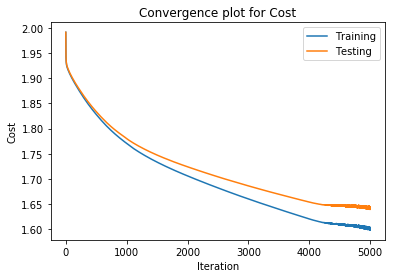

In [10]:
start=time.time
Neural=NeuralNetModel(hidden_layer_size=50,activation='relu',max_iter=5000,lambda2=0,lambda1=0,reg_type=None,learning_rate=.1e-1,percent=.5)
Neural.fit(X,T)
Neural.score(X,T)
end=time.time
print('duration = ',end-start)

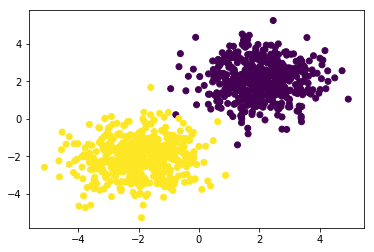

0: train cost: 0.5084887699626003, test cost: 0.5150435263516459
 train rate: 0.862, test rate: 0.838
100: train cost: 0.45653895447172954, test cost: 0.464752804908637
 train rate: 0.982, test rate: 0.95
200: train cost: 0.4127799136657005, test cost: 0.4223490509619719
 train rate: 0.988, test rate: 0.98
300: train cost: 0.3754611150374314, test cost: 0.3861098079381259
 train rate: 0.994, test rate: 0.99
400: train cost: 0.3433949070398009, test cost: 0.35494048026504665
 train rate: 0.994, test rate: 0.994
500: train cost: 0.3157200939193704, test cost: 0.3280071971271013
 train rate: 0.996, test rate: 0.996
600: train cost: 0.2915803580654578, test cost: 0.3045937688278436
 train rate: 0.998, test rate: 0.996
700: train cost: 0.2703775981324117, test cost: 0.284082981801918
 train rate: 0.998, test rate: 0.996
800: train cost: 0.25169941765166315, test cost: 0.26597836083980214
 train rate: 1.0, test rate: 0.996
900: train cost: 0.2351811898212407, test cost: 0.2499197711347326
 t

8100: train cost: 0.033668650316319, test cost: 0.044661210140975224
 train rate: 0.998, test rate: 0.994
8200: train cost: 0.033256084530240135, test cost: 0.044206457684431384
 train rate: 0.998, test rate: 0.994
8300: train cost: 0.03285392887426134, test cost: 0.043762781291559735
 train rate: 0.998, test rate: 0.994
8400: train cost: 0.032461710613265186, test cost: 0.04332996711697685
 train rate: 0.998, test rate: 0.994
8500: train cost: 0.03207882994356899, test cost: 0.04290745810432782
 train rate: 0.998, test rate: 0.994
8600: train cost: 0.03170501778170014, test cost: 0.04249491891621327
 train rate: 0.998, test rate: 0.994
8700: train cost: 0.03133994409661362, test cost: 0.042091803234958224
 train rate: 0.998, test rate: 0.994
8800: train cost: 0.03098328644972382, test cost: 0.04169782203961526
 train rate: 0.998, test rate: 0.994
8900: train cost: 0.030634765459866133, test cost: 0.04131284291299145
 train rate: 0.998, test rate: 0.994
9000: train cost: 0.030294171072

15700: train cost: 0.017590944728615224, test cost: 0.026804439744104517
 train rate: 0.998, test rate: 0.994
15800: train cost: 0.017485238234927123, test cost: 0.026686008430856147
 train rate: 0.998, test rate: 0.994
15900: train cost: 0.017380879473011927, test cost: 0.0265690945989662
 train rate: 0.998, test rate: 0.994
16000: train cost: 0.017277842777154277, test cost: 0.026453670029017017
 train rate: 0.998, test rate: 0.994
16100: train cost: 0.017176325608003116, test cost: 0.026339869185355923
 train rate: 0.998, test rate: 0.994
16200: train cost: 0.017076087017164163, test cost: 0.026227508066206547
 train rate: 0.998, test rate: 0.994
16300: train cost: 0.01697709257821209, test cost: 0.026116551736633156
 train rate: 0.998, test rate: 0.994
16400: train cost: 0.01687931918482449, test cost: 0.02600697804099007
 train rate: 0.998, test rate: 0.994
16500: train cost: 0.01678274429338748, test cost: 0.025898771283958545
 train rate: 0.998, test rate: 0.994
16600: train cos

23300: train cost: 0.012151210328971518, test cost: 0.020763328282140607
 train rate: 1.0, test rate: 0.994
23400: train cost: 0.012103295264261653, test cost: 0.020710934359390108
 train rate: 1.0, test rate: 0.994
23500: train cost: 0.012055785911401336, test cost: 0.02065900572660703
 train rate: 1.0, test rate: 0.994
23600: train cost: 0.012008692040299165, test cost: 0.020607551815920114
 train rate: 1.0, test rate: 0.994
23700: train cost: 0.011962000127323279, test cost: 0.020556560681645037
 train rate: 1.0, test rate: 0.994
23800: train cost: 0.011915698068058781, test cost: 0.02050601688317247
 train rate: 1.0, test rate: 0.994
23900: train cost: 0.011869780896635066, test cost: 0.020455915160447126
 train rate: 1.0, test rate: 0.994
24000: train cost: 0.011824243731165968, test cost: 0.020406261101296695
 train rate: 1.0, test rate: 0.994
24100: train cost: 0.011779081771992175, test cost: 0.020357118127782063
 train rate: 1.0, test rate: 0.994
24200: train cost: 0.011734290

31100: train cost: 0.009341458371050434, test cost: 0.017746105363069403
 train rate: 1.0, test rate: 0.994
31200: train cost: 0.009314537193291731, test cost: 0.01771790097337945
 train rate: 1.0, test rate: 0.994
31300: train cost: 0.009287782569592057, test cost: 0.017689892575595306
 train rate: 1.0, test rate: 0.994
31400: train cost: 0.009261192909238871, test cost: 0.01766208013194244
 train rate: 1.0, test rate: 0.994
31500: train cost: 0.00923476664191113, test cost: 0.01763445617732051
 train rate: 1.0, test rate: 0.994
31600: train cost: 0.009208516527448949, test cost: 0.017607025102129734
 train rate: 1.0, test rate: 0.994
31700: train cost: 0.009182447249785394, test cost: 0.017579788515423366
 train rate: 1.0, test rate: 0.994
31800: train cost: 0.009156539207795114, test cost: 0.017552737599077467
 train rate: 1.0, test rate: 0.994
31900: train cost: 0.009130787989845367, test cost: 0.017525879244173585
 train rate: 1.0, test rate: 0.994
32000: train cost: 0.00910520206

38800: train cost: 0.007661146594169801, test cost: 0.016026205070383968
 train rate: 1.0, test rate: 0.994
38900: train cost: 0.007643368661328386, test cost: 0.01600854917539605
 train rate: 1.0, test rate: 0.994
39000: train cost: 0.007625678210636499, test cost: 0.015990993395501425
 train rate: 1.0, test rate: 0.994
39100: train cost: 0.007608074577238568, test cost: 0.015973536955895932
 train rate: 1.0, test rate: 0.994
39200: train cost: 0.0075905571031101675, test cost: 0.01595617908965477
 train rate: 1.0, test rate: 0.994
39300: train cost: 0.007573125136970151, test cost: 0.015938919037632625
 train rate: 1.0, test rate: 0.994
39400: train cost: 0.007555778034194157, test cost: 0.01592175604836535
 train rate: 1.0, test rate: 0.994
39500: train cost: 0.007538515156729376, test cost: 0.015904689377973152
 train rate: 1.0, test rate: 0.994
39600: train cost: 0.007521335873010694, test cost: 0.015887718290065182
 train rate: 1.0, test rate: 0.994
39700: train cost: 0.007504239

46800: train cost: 0.00647153210254994, test cost: 0.01487613116662959
 train rate: 1.0, test rate: 0.994
46900: train cost: 0.006459180106454174, test cost: 0.014864480099613862
 train rate: 1.0, test rate: 0.994
47000: train cost: 0.006446880217984443, test cost: 0.014852886065582367
 train rate: 1.0, test rate: 0.994
47100: train cost: 0.006434634772357404, test cost: 0.014841349607729983
 train rate: 1.0, test rate: 0.994
47200: train cost: 0.006422438459294666, test cost: 0.01482986866859719
 train rate: 1.0, test rate: 0.994
47300: train cost: 0.00641029097457907, test cost: 0.014818442891621014
 train rate: 1.0, test rate: 0.994
47400: train cost: 0.006398192016553834, test cost: 0.014807071923232712
 train rate: 1.0, test rate: 0.994
47500: train cost: 0.006386141286095532, test cost: 0.014795755412826416
 train rate: 1.0, test rate: 0.994
47600: train cost: 0.006374144593093431, test cost: 0.014784493689110105
 train rate: 1.0, test rate: 0.994
47700: train cost: 0.00636220308

54500: train cost: 0.005647691995307536, test cost: 0.014121327814638153
 train rate: 1.0, test rate: 0.994
54600: train cost: 0.005638439680835805, test cost: 0.014113146768795848
 train rate: 1.0, test rate: 0.994
54700: train cost: 0.005629219234436316, test cost: 0.014105001007994887
 train rate: 1.0, test rate: 0.994
54800: train cost: 0.005620030487476407, test cost: 0.014096890334859714
 train rate: 1.0, test rate: 0.994
54900: train cost: 0.005610873272538894, test cost: 0.014088814553447732
 train rate: 1.0, test rate: 0.994
55000: train cost: 0.005601747423410991, test cost: 0.0140807734692363
 train rate: 1.0, test rate: 0.994
55100: train cost: 0.005592652775073331, test cost: 0.01407276688910996
 train rate: 1.0, test rate: 0.994
55200: train cost: 0.005583593249752187, test cost: 0.014064795798016626
 train rate: 1.0, test rate: 0.994
55300: train cost: 0.005574567589315103, test cost: 0.014056859696632841
 train rate: 1.0, test rate: 0.994
55400: train cost: 0.0055655725

62200: train cost: 0.00501923269774619, test cost: 0.013583406603227354
 train rate: 1.0, test rate: 0.994
62300: train cost: 0.005012042922078084, test cost: 0.013577480847882139
 train rate: 1.0, test rate: 0.994
62400: train cost: 0.00500487475990695, test cost: 0.013571578414936145
 train rate: 1.0, test rate: 0.994
62500: train cost: 0.004997728111985474, test cost: 0.013565699188891462
 train rate: 1.0, test rate: 0.994
62600: train cost: 0.0049906028796866345, test cost: 0.013559843054986137
 train rate: 1.0, test rate: 0.994
62700: train cost: 0.004983498964998763, test cost: 0.013554030144424944
 train rate: 1.0, test rate: 0.994
62800: train cost: 0.004976416270520689, test cost: 0.013548247499919164
 train rate: 1.0, test rate: 0.994
62900: train cost: 0.004969354699456889, test cost: 0.013542487509905044
 train rate: 1.0, test rate: 0.994
63000: train cost: 0.0049623141556127265, test cost: 0.013536750062908073
 train rate: 1.0, test rate: 0.994
63100: train cost: 0.0049552

70100: train cost: 0.004510816155723459, test cost: 0.01318088110251681
 train rate: 1.0, test rate: 0.994
70200: train cost: 0.004505070659345913, test cost: 0.013176514895934563
 train rate: 1.0, test rate: 0.994
70300: train cost: 0.004499340518494792, test cost: 0.013172164686709727
 train rate: 1.0, test rate: 0.994
70400: train cost: 0.004493625670831054, test cost: 0.013167830403477737
 train rate: 1.0, test rate: 0.994
70500: train cost: 0.004487926054359114, test cost: 0.01316351197528014
 train rate: 1.0, test rate: 0.994
70600: train cost: 0.004482242877434125, test cost: 0.013159209490775025
 train rate: 1.0, test rate: 0.994
70700: train cost: 0.0044765748885249555, test cost: 0.013154922729976988
 train rate: 1.0, test rate: 0.994
70800: train cost: 0.004470921936092026, test cost: 0.013150651611080817
 train rate: 1.0, test rate: 0.994
70900: train cost: 0.004465283959569742, test cost: 0.01314639606475465
 train rate: 1.0, test rate: 0.994
71000: train cost: 0.004459660

77800: train cost: 0.004109772800158827, test cost: 0.012887842560769996
 train rate: 1.0, test rate: 0.994
77900: train cost: 0.004105058207914581, test cost: 0.012884542286528933
 train rate: 1.0, test rate: 0.994
78000: train cost: 0.004100361967500946, test cost: 0.012881269480945099
 train rate: 1.0, test rate: 0.994
78100: train cost: 0.004095678604782259, test cost: 0.012878011680089023
 train rate: 1.0, test rate: 0.994
78200: train cost: 0.00409100648729428, test cost: 0.012874765146432694
 train rate: 1.0, test rate: 0.994
78300: train cost: 0.004086345574259812, test cost: 0.01287152983419409
 train rate: 1.0, test rate: 0.994
78400: train cost: 0.004081695825101276, test cost: 0.012868305697826196
 train rate: 1.0, test rate: 0.994
78500: train cost: 0.004077057199439461, test cost: 0.012865092692015589
 train rate: 1.0, test rate: 0.994
78600: train cost: 0.004072429657092283, test cost: 0.01286189077168089
 train rate: 1.0, test rate: 0.994
78700: train cost: 0.0040678131

85900: train cost: 0.003762168883096356, test cost: 0.01266794126073391
 train rate: 1.0, test rate: 0.994
86000: train cost: 0.003758268330106243, test cost: 0.01266565230011158
 train rate: 1.0, test rate: 0.994
86100: train cost: 0.0037543762979998824, test cost: 0.012663371444126997
 train rate: 1.0, test rate: 0.994
86200: train cost: 0.003750492758747467, test cost: 0.012661098662066033
 train rate: 1.0, test rate: 0.994
86300: train cost: 0.003746617684443139, test cost: 0.01265883392335944
 train rate: 1.0, test rate: 0.994
86400: train cost: 0.003742751047304309, test cost: 0.012656577197581943
 train rate: 1.0, test rate: 0.994
86500: train cost: 0.003738892819670911, test cost: 0.01265432845445144
 train rate: 1.0, test rate: 0.994
86600: train cost: 0.003735042974004763, test cost: 0.012652087663828231
 train rate: 1.0, test rate: 0.994
86700: train cost: 0.0037312014828888578, test cost: 0.01264985479571413
 train rate: 1.0, test rate: 0.994
86800: train cost: 0.0037273683

93500: train cost: 0.0034886330833563076, test cost: 0.012515019998099864
 train rate: 1.0, test rate: 0.994
93600: train cost: 0.003485315199166323, test cost: 0.012513267392114946
 train rate: 1.0, test rate: 0.994
93700: train cost: 0.003482003981450986, test cost: 0.012511520916612878
 train rate: 1.0, test rate: 0.994
93800: train cost: 0.0034786994100721356, test cost: 0.012509780549903976
 train rate: 1.0, test rate: 0.994
93900: train cost: 0.0034754014649730674, test cost: 0.012508046270393177
 train rate: 1.0, test rate: 0.994
94000: train cost: 0.0034721101261781114, test cost: 0.012506318056579709
 train rate: 1.0, test rate: 0.994
94100: train cost: 0.003468825373792228, test cost: 0.012504595887056477
 train rate: 1.0, test rate: 0.994
94200: train cost: 0.003465547188000554, test cost: 0.012502879740509634
 train rate: 1.0, test rate: 0.994
94300: train cost: 0.003462275549068047, test cost: 0.012501169595718033
 train rate: 1.0, test rate: 0.994
94400: train cost: 0.003

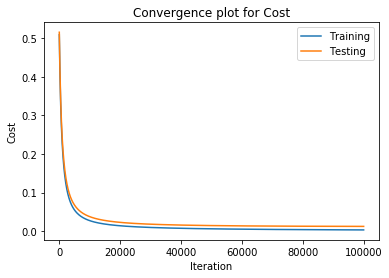

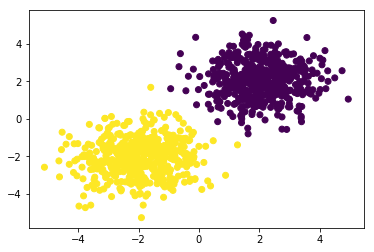

In [155]:
#Try code on simple dataset
n_samp=500
X_g1=np.random.randn(n_samp,2)+np.array([2,2])
X_g2=np.random.randn(n_samp,2)+np.array([-2,-2])
X_g=np.concatenate([X_g1,X_g2],axis=0)
T_g=np.array([0]*n_samp+[1]*n_samp)

plt.figure()
plt.scatter(X_g[:,0],X_g[:,1],c=T_g)
plt.show()

Neural1=NeuralNetModel(hidden_layer_size=10,activation='sigmoid',max_iter=100000,lambda2=0,lambda1=0,reg_type=None,learning_rate=.5e-3,percent=.5)
Neural1.fit(X_g,T_g)

predY_g=Neural1.predict(X_g)


plt.figure()
plt.scatter(X_g[:,0],X_g[:,1],c=predY_g)
plt.show()

(array([0., 0., 0., ..., 6., 6., 6.]),
 array([[0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
         0.32156863],
        [0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
         0.32156863],
        [0.59215686, 0.58823529, 0.57647059, ..., 0.75686275, 0.71764706,
         0.72156863],
        ...,
        [0.11372549, 0.11372549, 0.10588235, ..., 0.05882353, 0.10196078,
         0.23529412],
        [0.54509804, 0.56078431, 0.56862745, ..., 0.38823529, 0.74509804,
         0.8627451 ],
        [0.19607843, 0.14117647, 0.06666667, ..., 0.8745098 , 0.86666667,
         0.84705882]]))

In [113]:
print(Wb_init_def)

def Wb_init(X,T,hidden_layer_sizes):
    D=X.shape[1]
    K=T.shape[1]
    M=[D]+list(hidden_layer_sizes)+[K]
    W_init=[]
    b_init=[]
    W_1=np.random.randn(*(M[0],M[1]))
    W_init.append(W_1)
    b_1=np.random.randn(M[1],1)
    b_init.append(b_1)
    return W_init,b_init
    W_2=np.random.randn(*(M[1],M[2]))
    W_init.append(W_2)
    b_2=np.random.randn(M[2],1)
    b_init.append(b_2)
    return W_init,b_init
    W_3=np.random.randn(*(M[2],M[3]))
    W_init.append(W_3)
    b_3=np.random.randn(M[3],1)
    b_init.append(b_3)
    return W_init,b_init
    W_4=np.random.randn(*(M[3],M[4]))
    W_init.append(W_4)
    b_4=np.random.randn(M[4],1)
    b_init.append(b_4)
    return W_init,b_init
    W_5=np.random.randn(*(M[4],M[5]))
    W_init.append(W_5)
    b_5=np.random.randn(M[5],1)
    b_init.append(b_5)
    return W_init,b_init
    W_6=np.random.randn(*(M[5],M[6]))
    W_init.append(W_6)
    b_6=np.random.randn(M[6],1)
    b_init.append(b_6)
    return W_init,b_init


In [29]:
np.ones((3,3))+np.array([[1,2,3]])

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

In [ ]:
act,d_act

In [156]:
H=5


In [157]:
print(d_Wb_def)

def d_Wb(T,X,Y,Z,E,W,b):
    H=len(W)-1
    Z_0=X
    E_1,E_2,E_3,E_4,E_5 = E
    Z_1,Z_2,Z_3,Z_4,Z_5 = Z
    W_1,W_2,W_3,W_4,W_5,W_6 = W
    b_1,b_2,b_3,b_4,b_5,b_6 = b
    
    del_0=(Y-T)
    del_1=(del_0.dot(W_6.T))*d_act(E_5)
    del_2=(del_1.dot(W_5.T))*d_act(E_4)
    del_3=(del_2.dot(W_4.T))*d_act(E_3)
    del_4=(del_3.dot(W_3.T))*d_act(E_2)
    del_5=(del_4.dot(W_2.T))*d_act(E_1)
    d_W=[]
    d_W_1=Z_0.T.dot(del_5)
    d_W.append(d_W_1)
    d_W_2=Z_1.T.dot(del_4)
    d_W.append(d_W_2)
    d_W_3=Z_2.T.dot(del_3)
    d_W.append(d_W_3)
    d_W_4=Z_3.T.dot(del_2)
    d_W.append(d_W_4)
    d_W_5=Z_4.T.dot(del_1)
    d_W.append(d_W_5)
    d_W_6=Z_5.T.dot(del_0)
    d_W.append(d_W_6)
    d_b=[]
    d_b_1=np.sum(del_5,axis=0,keep_dims=True)
    d_b.append(d_b_1)
    d_b_2=np.sum(del_4,axis=0,keep_dims=True)
    d_b.append(d_b_2)
    d_b_3=np.sum(del_3,axis=0,keep_dims=True)
    d_b.append(d_b_3)
    d_b_4=np.sum(del_2,axis=0,keep_dims=True)
    d_b.append(d_b_4)
    d_b_5=np.sum(del_

In [188]:

def create_forward_and_gradient_and_init_fun_strings(hidden_layer_sizes):
    H=len(hidden_layer_sizes)
    tab="\n    "#skips to next line and indents
    
    # Below code automaticaly creates weight and bias initialization matrices for neural net
    Wb_init_def="def Wb_init(X,T,hidden_layer_sizes):"
    Wb_init_def+=tab+"D=X.shape[1]"+tab+"K=T.shape[1]"
    Wb_init_def+=tab+"M=[D]+list(hidden_layer_sizes)+[K]"
    Wb_init_def+=tab+"W_init=[]"+tab+"b_init=[]"
    for h in range(1,H+2):
        Wb_init_def+=tab+"W_%s=np.random.randn(*(M[%s],M[%s]))"%(h,h-1,h)
        Wb_init_def+=tab+"W_init.append(W_%s)"%(h)
        Wb_init_def+=tab+"b_%s=np.random.randn(M[%s],1)"%(h,h)
        Wb_init_def+=tab+"b_init.append(b_%s)"%(h)
        Wb_init_def+=tab+"return W_init,b_init"
        
    #Below code automaticaly generates forward function for neural net
    for_list="\n    Z_0=X"
    for_list+=tab+"E,Z=[],[]"
    for h in range(1,H+1):
        for_list+=tab+"E_%s=Z_%s.dot(W_%s)+b_%s.T"%(h,h-1,h,h)
        for_list+=tab+"E.append(E_%s)"%(h)
        for_list+=tab+"Z_%s=act(E_%s)"%(h,h)
        for_list+=tab+"Z.append(Z_%s)"%(h)
    for_list+=tab+"Y=softmax(Z_%s.dot(W_%s)+b_%s.T)"%(H,H+1,H+1)
    forward_def="def forward(X,W,b):"

    W_str_list="\n    "
    for i in range(H):
        W_str_list+="W_%s,"%(i+1)
    W_str_list+="W_%s=W"%(H+1)

    b_str_list="\n    "
    for i in range(H):
        b_str_list+="b_%s,"%(i+1)
    b_str_list+="b_%s=b"%(H+1)

    return_list=tab*2+"return Y,Z,E"
    forward_def+=tab+""+W_str_list+b_str_list+for_list+return_list
    
    #Below code generates Gradient function for neural nets
    d_Wb_def="def d_Wb(T,X,Y,Z,E,W,b):"

    d_Wb_def+=tab+"Z_0=X"

    d_Wb_def+=tab
    for h in range(1,H):
        d_Wb_def+="E_%s,"%(h)
    d_Wb_def+="E_%s = E"%(H)

    d_Wb_def+=tab
    for h in range(1,H):
        d_Wb_def+="Z_%s,"%(h)
    d_Wb_def+="Z_%s = Z"%(H)

    d_Wb_def+=tab
    for h in range(1,H+1):
        d_Wb_def+="W_%s,"%(h)
    d_Wb_def+="W_%s = W"%(H+1)

    d_Wb_def+=tab
    for h in range(1,H+1):
        d_Wb_def+="b_%s,"%(h)
    d_Wb_def+="b_%s = b"%(H+1)+tab


    del_list=tab+"del_0=(Y-T)"
    for h in range(1,H+1):
        del_list+=tab+"del_%s=(del_%s.dot(W_%s.T))*d_act(E_%s)"%(h,h-1,H+2-h,H+1-h)
    d_W_str=tab+"d_W=[]"
    d_b_str=tab+"d_b=[]"

    for h in range(1,H+2):
        d_W_str+=tab+"d_W_%s=Z_%s.T.dot(del_%s)"%(h,h-1,H+1-h)
        d_W_str+=tab+"d_W.append(d_W_%s)"%(h)
        d_b_str+=tab+"d_b_%s=np.sum(del_%s,axis=0,keep_dims=True)"%(h,H+1-h)
        d_b_str+=tab+"d_b.append(d_b_%s)"%(h)

    d_list=del_list+d_W_str+d_b_str    
    d_Wb_def+=d_list+tab*2+"return d_W,d_b"
    
    #Below functions are put into list and returned as functions and as strings
    print(forward_def)
    print(Wb_init_def)
    print(d_Wb_def)
    def_strings=[Wb_init_def,forward_def,d_Wb_def]


    return def_strings

In [189]:
def_strings=create_forward_and_gradient_and_init_fun_strings((1,1,1,1,1,1,1,1,1,1,1,1,1,1))

def forward(X,W,b):
    
    W_1,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9,W_10,W_11,W_12,W_13,W_14,W_15=W
    b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10,b_11,b_12,b_13,b_14,b_15=b
    Z_0=X
    E,Z=[],[]
    E_1=Z_0.dot(W_1)+b_1.T
    E.append(E_1)
    Z_1=act(E_1)
    Z.append(Z_1)
    E_2=Z_1.dot(W_2)+b_2.T
    E.append(E_2)
    Z_2=act(E_2)
    Z.append(Z_2)
    E_3=Z_2.dot(W_3)+b_3.T
    E.append(E_3)
    Z_3=act(E_3)
    Z.append(Z_3)
    E_4=Z_3.dot(W_4)+b_4.T
    E.append(E_4)
    Z_4=act(E_4)
    Z.append(Z_4)
    E_5=Z_4.dot(W_5)+b_5.T
    E.append(E_5)
    Z_5=act(E_5)
    Z.append(Z_5)
    E_6=Z_5.dot(W_6)+b_6.T
    E.append(E_6)
    Z_6=act(E_6)
    Z.append(Z_6)
    E_7=Z_6.dot(W_7)+b_7.T
    E.append(E_7)
    Z_7=act(E_7)
    Z.append(Z_7)
    E_8=Z_7.dot(W_8)+b_8.T
    E.append(E_8)
    Z_8=act(E_8)
    Z.append(Z_8)
    E_9=Z_8.dot(W_9)+b_9.T
    E.append(E_9)
    Z_9=act(E_9)
    Z.append(Z_9)
    E_10=Z_9.dot(W_10)+b_10.T
    E.append(E_10)
    Z_10=act(E_10)
    Z.append(Z_10)


In [190]:
exec(def_strings[0])

In [192]:
exec(def_strings[1])

In [194]:
forward

<function __main__.forward>

In [174]:
def d_Wb(T,X,Y,Z,E,W,b):
    Z_0=X
    E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12,E_13,E_14 = E
    Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14 = Z
    W_1,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9,W_10,W_11,W_12,W_13,W_14,W_15 = W
    b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10,b_11,b_12,b_13,b_14,b_15 = b
    
    del_0=(Y-T)
    del_1=(del_0.dot(W_15.T))*d_act(E_14)
    del_2=(del_1.dot(W_14.T))*d_act(E_13)
    del_3=(del_2.dot(W_13.T))*d_act(E_12)
    del_4=(del_3.dot(W_12.T))*d_act(E_11)
    del_5=(del_4.dot(W_11.T))*d_act(E_10)
    del_6=(del_5.dot(W_10.T))*d_act(E_9)
    del_7=(del_6.dot(W_9.T))*d_act(E_8)
    del_8=(del_7.dot(W_8.T))*d_act(E_7)
    del_9=(del_8.dot(W_7.T))*d_act(E_6)
    del_10=(del_9.dot(W_6.T))*d_act(E_5)
    del_11=(del_10.dot(W_5.T))*d_act(E_4)
    del_12=(del_11.dot(W_4.T))*d_act(E_3)
    del_13=(del_12.dot(W_3.T))*d_act(E_2)
    del_14=(del_13.dot(W_2.T))*d_act(E_1)
    d_W=[]
    d_W_1=Z_0.T.dot(del_14)
    d_W.append(d_W_1)
    d_W_2=Z_1.T.dot(del_13)
    d_W.append(d_W_2)
    d_W_3=Z_2.T.dot(del_12)
    d_W.append(d_W_3)
    d_W_4=Z_3.T.dot(del_11)
    d_W.append(d_W_4)
    d_W_5=Z_4.T.dot(del_10)
    d_W.append(d_W_5)
    d_W_6=Z_5.T.dot(del_9)
    d_W.append(d_W_6)
    d_W_7=Z_6.T.dot(del_8)
    d_W.append(d_W_7)
    d_W_8=Z_7.T.dot(del_7)
    d_W.append(d_W_8)
    d_W_9=Z_8.T.dot(del_6)
    d_W.append(d_W_9)
    d_W_10=Z_9.T.dot(del_5)
    d_W.append(d_W_10)
    d_W_11=Z_10.T.dot(del_4)
    d_W.append(d_W_11)
    d_W_12=Z_11.T.dot(del_3)
    d_W.append(d_W_12)
    d_W_13=Z_12.T.dot(del_2)
    d_W.append(d_W_13)
    d_W_14=Z_13.T.dot(del_1)
    d_W.append(d_W_14)
    d_W_15=Z_14.T.dot(del_0)
    d_W.append(d_W_15)
    d_b=[]
    d_b_1=np.sum(del_14,axis=0,keep_dims=True)
    d_b.append(d_b_1)
    d_b_2=np.sum(del_13,axis=0,keep_dims=True)
    d_b.append(d_b_2)
    d_b_3=np.sum(del_12,axis=0,keep_dims=True)
    d_b.append(d_b_3)
    d_b_4=np.sum(del_11,axis=0,keep_dims=True)
    d_b.append(d_b_4)
    d_b_5=np.sum(del_10,axis=0,keep_dims=True)
    d_b.append(d_b_5)
    d_b_6=np.sum(del_9,axis=0,keep_dims=True)
    d_b.append(d_b_6)
    d_b_7=np.sum(del_8,axis=0,keep_dims=True)
    d_b.append(d_b_7)
    d_b_8=np.sum(del_7,axis=0,keep_dims=True)
    d_b.append(d_b_8)
    d_b_9=np.sum(del_6,axis=0,keep_dims=True)
    d_b.append(d_b_9)
    d_b_10=np.sum(del_5,axis=0,keep_dims=True)
    d_b.append(d_b_10)
    d_b_11=np.sum(del_4,axis=0,keep_dims=True)
    d_b.append(d_b_11)
    d_b_12=np.sum(del_3,axis=0,keep_dims=True)
    d_b.append(d_b_12)
    d_b_13=np.sum(del_2,axis=0,keep_dims=True)
    d_b.append(d_b_13)
    d_b_14=np.sum(del_1,axis=0,keep_dims=True)
    d_b.append(d_b_14)
    d_b_15=np.sum(del_0,axis=0,keep_dims=True)
    d_b.append(d_b_15)
    
    return d_W,d_b

In [175]:
d_Wb

<function __main__.d_Wb>

In [162]:
a="def aaa():"+tab+"return 1"

In [164]:
print(a)

def aaa():
    return 1


In [166]:
exec(a)

In [167]:
aaa

<function __main__.aaa>